In [1]:
%matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib
import axelrod as axl
import imp
import csv

assert pd.__version__ == "0.20.2"
assert np.__version__ == '1.12.1'
assert axl.__version__ == '2.13.0'
assert matplotlib.__version__ == "2.0.2"

import players
player_names = list(map(str, players.players))
number_of_digits = 3  # Number of digits to round for LaTeX tables

turns = 200
number_of_players = len(player_names)

assert number_of_players == 176

abbreviations = imp.load_source('abbreviations', '../src/abbreviations.py')
from abbreviations import abbreviations

def abbreviate(player_name, abbreviations=abbreviations):
    """
    Return the abbreviated name of a play if one has been given
    """
    if isinstance(player_name, axl.Player):
        player_name = str(player_name)
    return abbreviations.get(player_name, player_name)

assert abbreviate("Tit For Tat") == "TfT"
assert abbreviate("Random: 0.5") == "Random"
assert abbreviate(axl.TitForTat()) == "TfT"

with open("./reference_keys.csv", "r") as f:
    reader = csv.reader(f)
    reference_keys = {player: eval(keys) for player, keys in reader}
    
assert reference_keys['ALLCorALLD'] == ['axelrodproject']
assert reference_keys['Cooperator'] == ['Axelrod1984', 'Mittal2009', 'Press2012']

def clean_latex(string):
    """Replace some special carachters"""
    string = string.replace("textbackslashpi", "pi")
    string = string.replace("textbackslashphi", "phi")
    string = string.replace("\\$", "$")
    string = string.replace("\\$", "$")
    string = string.replace("\\textasciicircum", "^")
    string = string.replace("\_", "_")
    string = string.replace("2_2_2", "2\_2\_2")
    string = string.replace("1_1_1", "1\_1\_1")
    return string

# Write player appendix

In [2]:
with open("../assets/list_of_players.tex", "w") as f:
    for player in sorted(players.players, key=str):
        latex_name = "{}".format(player).replace("_", "\_")
        f.write("\item {}".format(latex_name))
        abbreviation = abbreviate(player)
        if abbreviation != player.name:
            f.write(" (\\textbf{{{}}})".format(abbreviation))
        if player.classifier["stochastic"]:
            f.write(" - \\textit{Stochastic}")
        else:
            f.write(" - \\textit{Deterministic}")
        try:
            mem = int(player.classifier["memory_depth"])
        except OverflowError:
            mem = "\(\infty\)"
        f.write(" - \\textit{{Memory depth}}: {}".format(mem))
        try:
            f.write(". \cite{{{}}}\n".format(", ".join(sorted(reference_keys[str(player)]))))
        except KeyError:
            f.write(".\n")

# Study the standard tournaments

## Scores

In [3]:
def read_scores(files):
    dfs = []
    for gz in files:
        if "scores" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    df /= turns * (number_of_players - 1)  # Scale all scores
    return df

In [4]:
standard_files = glob.glob("./data/*_0_1000*gz")
scores = read_scores(files=standard_files)

In [5]:
with open("../assets/standard_number_of_repetitions.tex", "w") as f:
    f.write(str(len(scores.index)))

In [6]:
def summarise_scores(scores):
    df = scores.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    df.drop('count', axis=1, inplace=True)
    return df

score_summary = summarise_scores(scores)
score_summary.head(15)

mean       std       min        5%       25%  \
EvolvedLookerUp2_2_2     2.955003  0.010299  2.915286  2.937143  2.948114   
Evolved HMM 5            2.954320  0.013932  2.902600  2.931257  2.944600   
Evolved FSM 16           2.952329  0.013209  2.900371  2.929657  2.943371   
PSO Gambler 2_2_2        2.938453  0.013294  2.884400  2.913571  2.929971   
Evolved FSM 16 Noise 05  2.919015  0.012533  2.873800  2.898200  2.910457   
PSO Gambler 1_1_1        2.911933  0.023428  2.809600  2.873429  2.896143   
Evolved ANN 5            2.911666  0.010209  2.870857  2.894257  2.904657   
Evolved FSM 4            2.909651  0.012080  2.867914  2.889200  2.901229   
Evolved ANN              2.907230  0.010023  2.865229  2.890257  2.900486   
PSO Gambler Mem1         2.901019  0.025401  2.782943  2.858427  2.883743   
Evolved ANN 5 Noise 05   2.864213  0.008250  2.830314  2.850229  2.858400   
DBS: 0.75, 3, 4, 3, 5    2.857133  0.008875  2.822743  2.842457  2.850971   
Winner12                 2.849319  0.008063  2.820000  2.835686  2.843514   
Fool Me Once             2.843964  0.008166  2.819229  2.830514  2.838000   
Omega TFT: 3, 8          2.840913  0.011318  2.800257  2.822029  2.833114   

                              50%       75%       95%       max  
EvolvedLookerUp2_2_2     2.955543  2.962543  2.970857  2.989400  
Evolved HMM 5            2.954400  2.963971  2.977086  3.007400  
Evolved FSM 16           2.952943  2.961886  2.973029  2.993171  
PSO Gambler 2_2_2        2.940171  2.948457  2.957343  2.972400  
Evolved FSM 16 Noise 05  2.919057  2.927686  2.939457  2.964457  
PSO Gambler 1_1_1        2.912114  2.927800  2.950229  3.011857  
Evolved ANN 5            2.911943  2.919229  2.927744  2.944543  
Evolved FSM 4            2.910257  2.918486  2.928543  2.942629  
Evolved ANN              2.907543  2.914429  2.923086  2.941629  
PSO Gambler Mem1         2.901314  2.918600  2.942400  2.994429  
Evolved ANN 5 Noise 05   2.864571  2.870371  2.877057  2.890943  
DBS: 0.75, 3, 4, 3, 5    2.857200  2.863343  2.871657  2.899371  
Winner12                 2.849743  2.855314  2.861914  2.873743  
Fool Me Once             2.844257  2.849657  2.857171  2.881943  
Omega TFT: 3, 8          2.841057  2.848800  2.859371  2.882143

In [7]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(score_summary.head(15).round(number_of_digits).to_latex()))

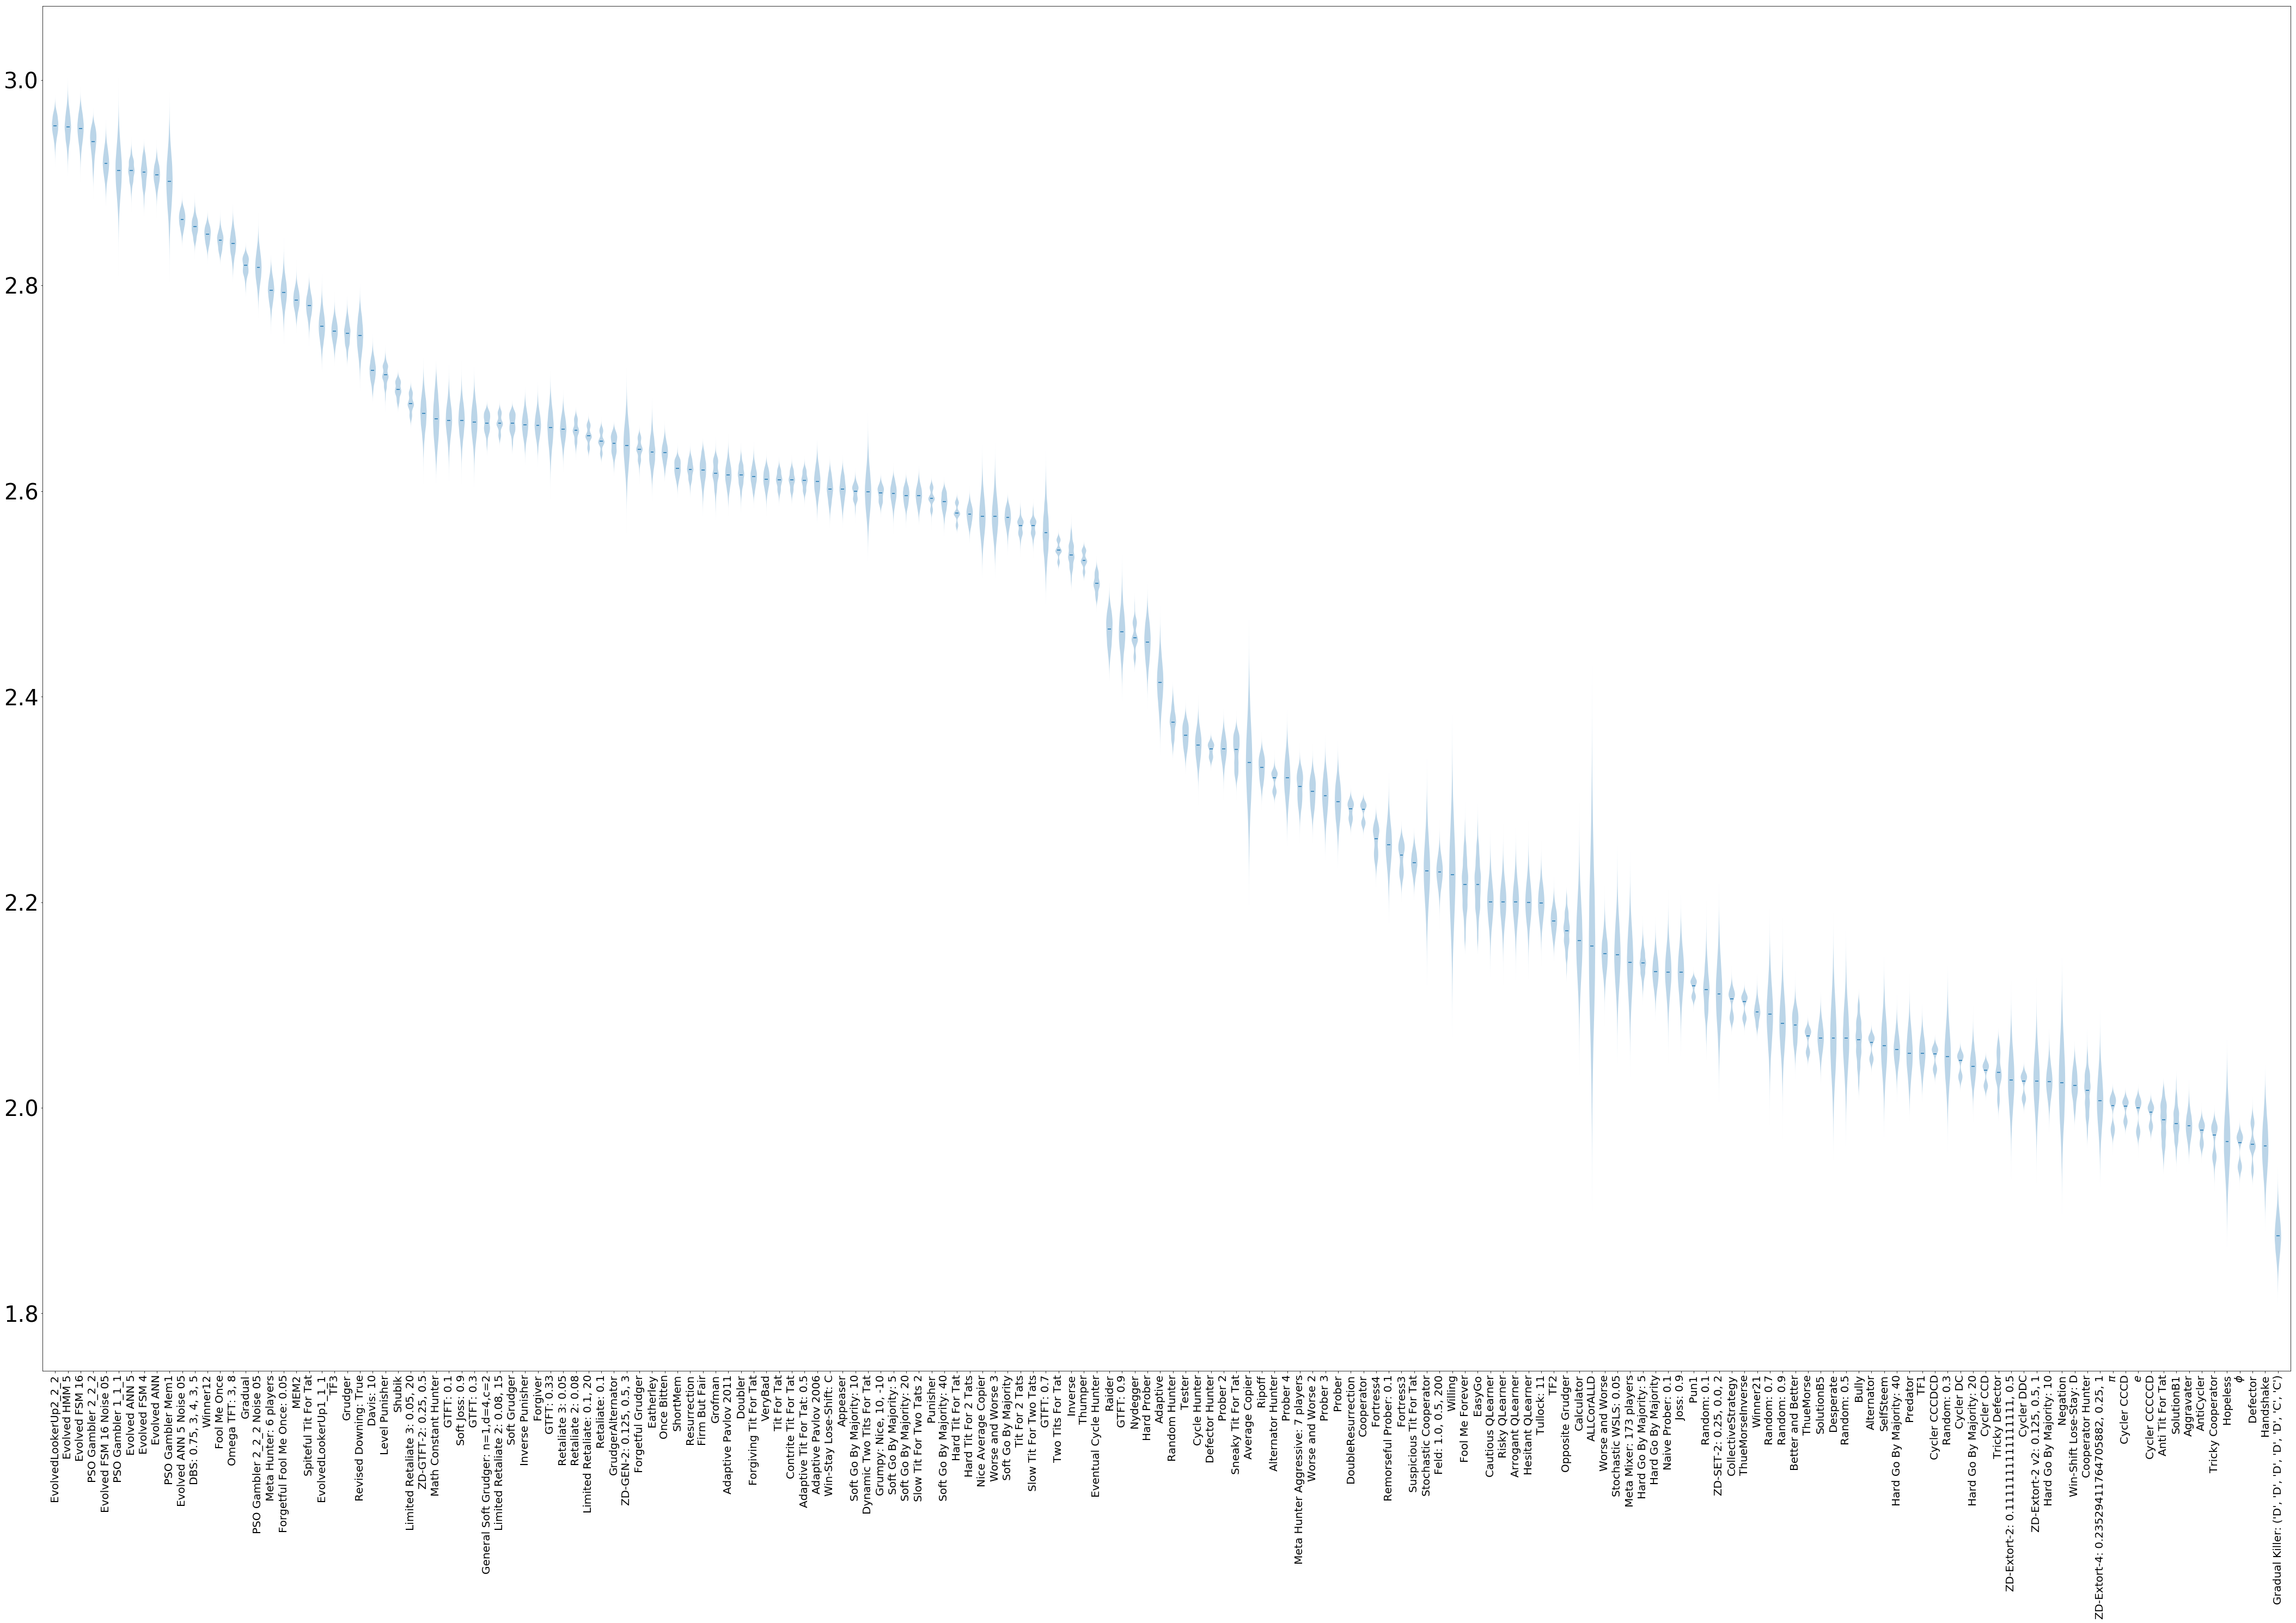

In [8]:
def violon_plot(scores, summary, filename):
    fig, ax = plt.subplots() 
    width = number_of_players / 3
    height = width / 1.414
    spacing = 4 
    positions = spacing * np.arange(1, number_of_players + 1, 1)
    fig.set_size_inches(width, height) 

    ax.violinplot([scores[player] for player in summary.index],
                  positions=positions, widths=spacing / 2,
                  showmedians=True, showextrema=False)
    ax.set_xticks(positions) 
    ax.set_xticklabels(summary.index, rotation=90)
    ax.set_xlim([0, spacing * (number_of_players + 1)])
    ax.tick_params(axis='x', which='both', labelsize=20)
    ax.tick_params(axis='y', which='both', labelsize=40)
    fig.tight_layout()
    fig.savefig(filename);
    
violon_plot(scores, score_summary, "../assets/standard_scores_boxplots.pdf")

## Ranks

Every row corresponds to a tournament. We can see the ranks of each strategy across the tournament repetitions.

In [9]:
def summarise_ranks(scores):
    df = scores.rank(axis=1, ascending=False).describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean")
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    return df

rank_summary = summarise_ranks(scores)
rank_summary.head(15)

mean       std  min    5%   25%   50%   75%  \
EvolvedLookerUp2_2_2      2.171256  1.069476    1   1.0   1.0   2.0   3.0   
Evolved HMM 5             2.324919  1.274967    1   1.0   1.0   2.0   3.0   
Evolved FSM 16            2.488430  1.298910    1   1.0   1.0   2.0   3.0   
PSO Gambler 2_2_2         3.961419  1.526870    1   2.0   3.0   4.0   5.0   
Evolved FSM 16 Noise 05   6.298384  1.688061    1   4.0   5.0   6.0   7.0   
PSO Gambler 1_1_1         7.090826  2.504495    1   3.0   5.0   7.0   9.0   
Evolved ANN 5             7.285430  1.523711    2   5.0   6.0   7.0   8.0   
Evolved FSM 4             7.521419  1.629663    2   5.0   6.0   8.0   9.0   
Evolved ANN               7.898581  1.449995    2   5.0   7.0   8.0   9.0   
PSO Gambler Mem1          8.223337  2.533601    1   4.0   6.0   9.0  10.0   
Evolved ANN 5 Noise 05   11.361837  0.872226    8  10.0  11.0  11.0  12.0   
DBS: 0.75, 3, 4, 3, 5    12.190826  1.121198    9  11.0  11.0  12.0  13.0   
Winner12                 13.224151  1.135823    9  11.0  12.0  13.0  14.0   
Fool Me Once             13.960581  1.080475    9  12.0  13.0  14.0  15.0   
Omega TFT: 3, 8          14.274453  1.300103    9  12.0  13.0  15.0  15.0   

                          95%  max  
EvolvedLookerUp2_2_2      4.0    8  
Evolved HMM 5             5.0   10  
Evolved FSM 16            5.0   10  
PSO Gambler 2_2_2         7.0   10  
Evolved FSM 16 Noise 05   9.0   11  
PSO Gambler 1_1_1        10.0   17  
Evolved ANN 5            10.0   11  
Evolved FSM 4            10.0   12  
Evolved ANN              10.0   12  
PSO Gambler Mem1         12.0   20  
Evolved ANN 5 Noise 05   13.0   16  
DBS: 0.75, 3, 4, 3, 5    14.0   16  
Winner12                 15.0   17  
Fool Me Once             15.0   17  
Omega TFT: 3, 8          16.0   19

In [10]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(rank_summary.head(15).round(number_of_digits).to_latex()))

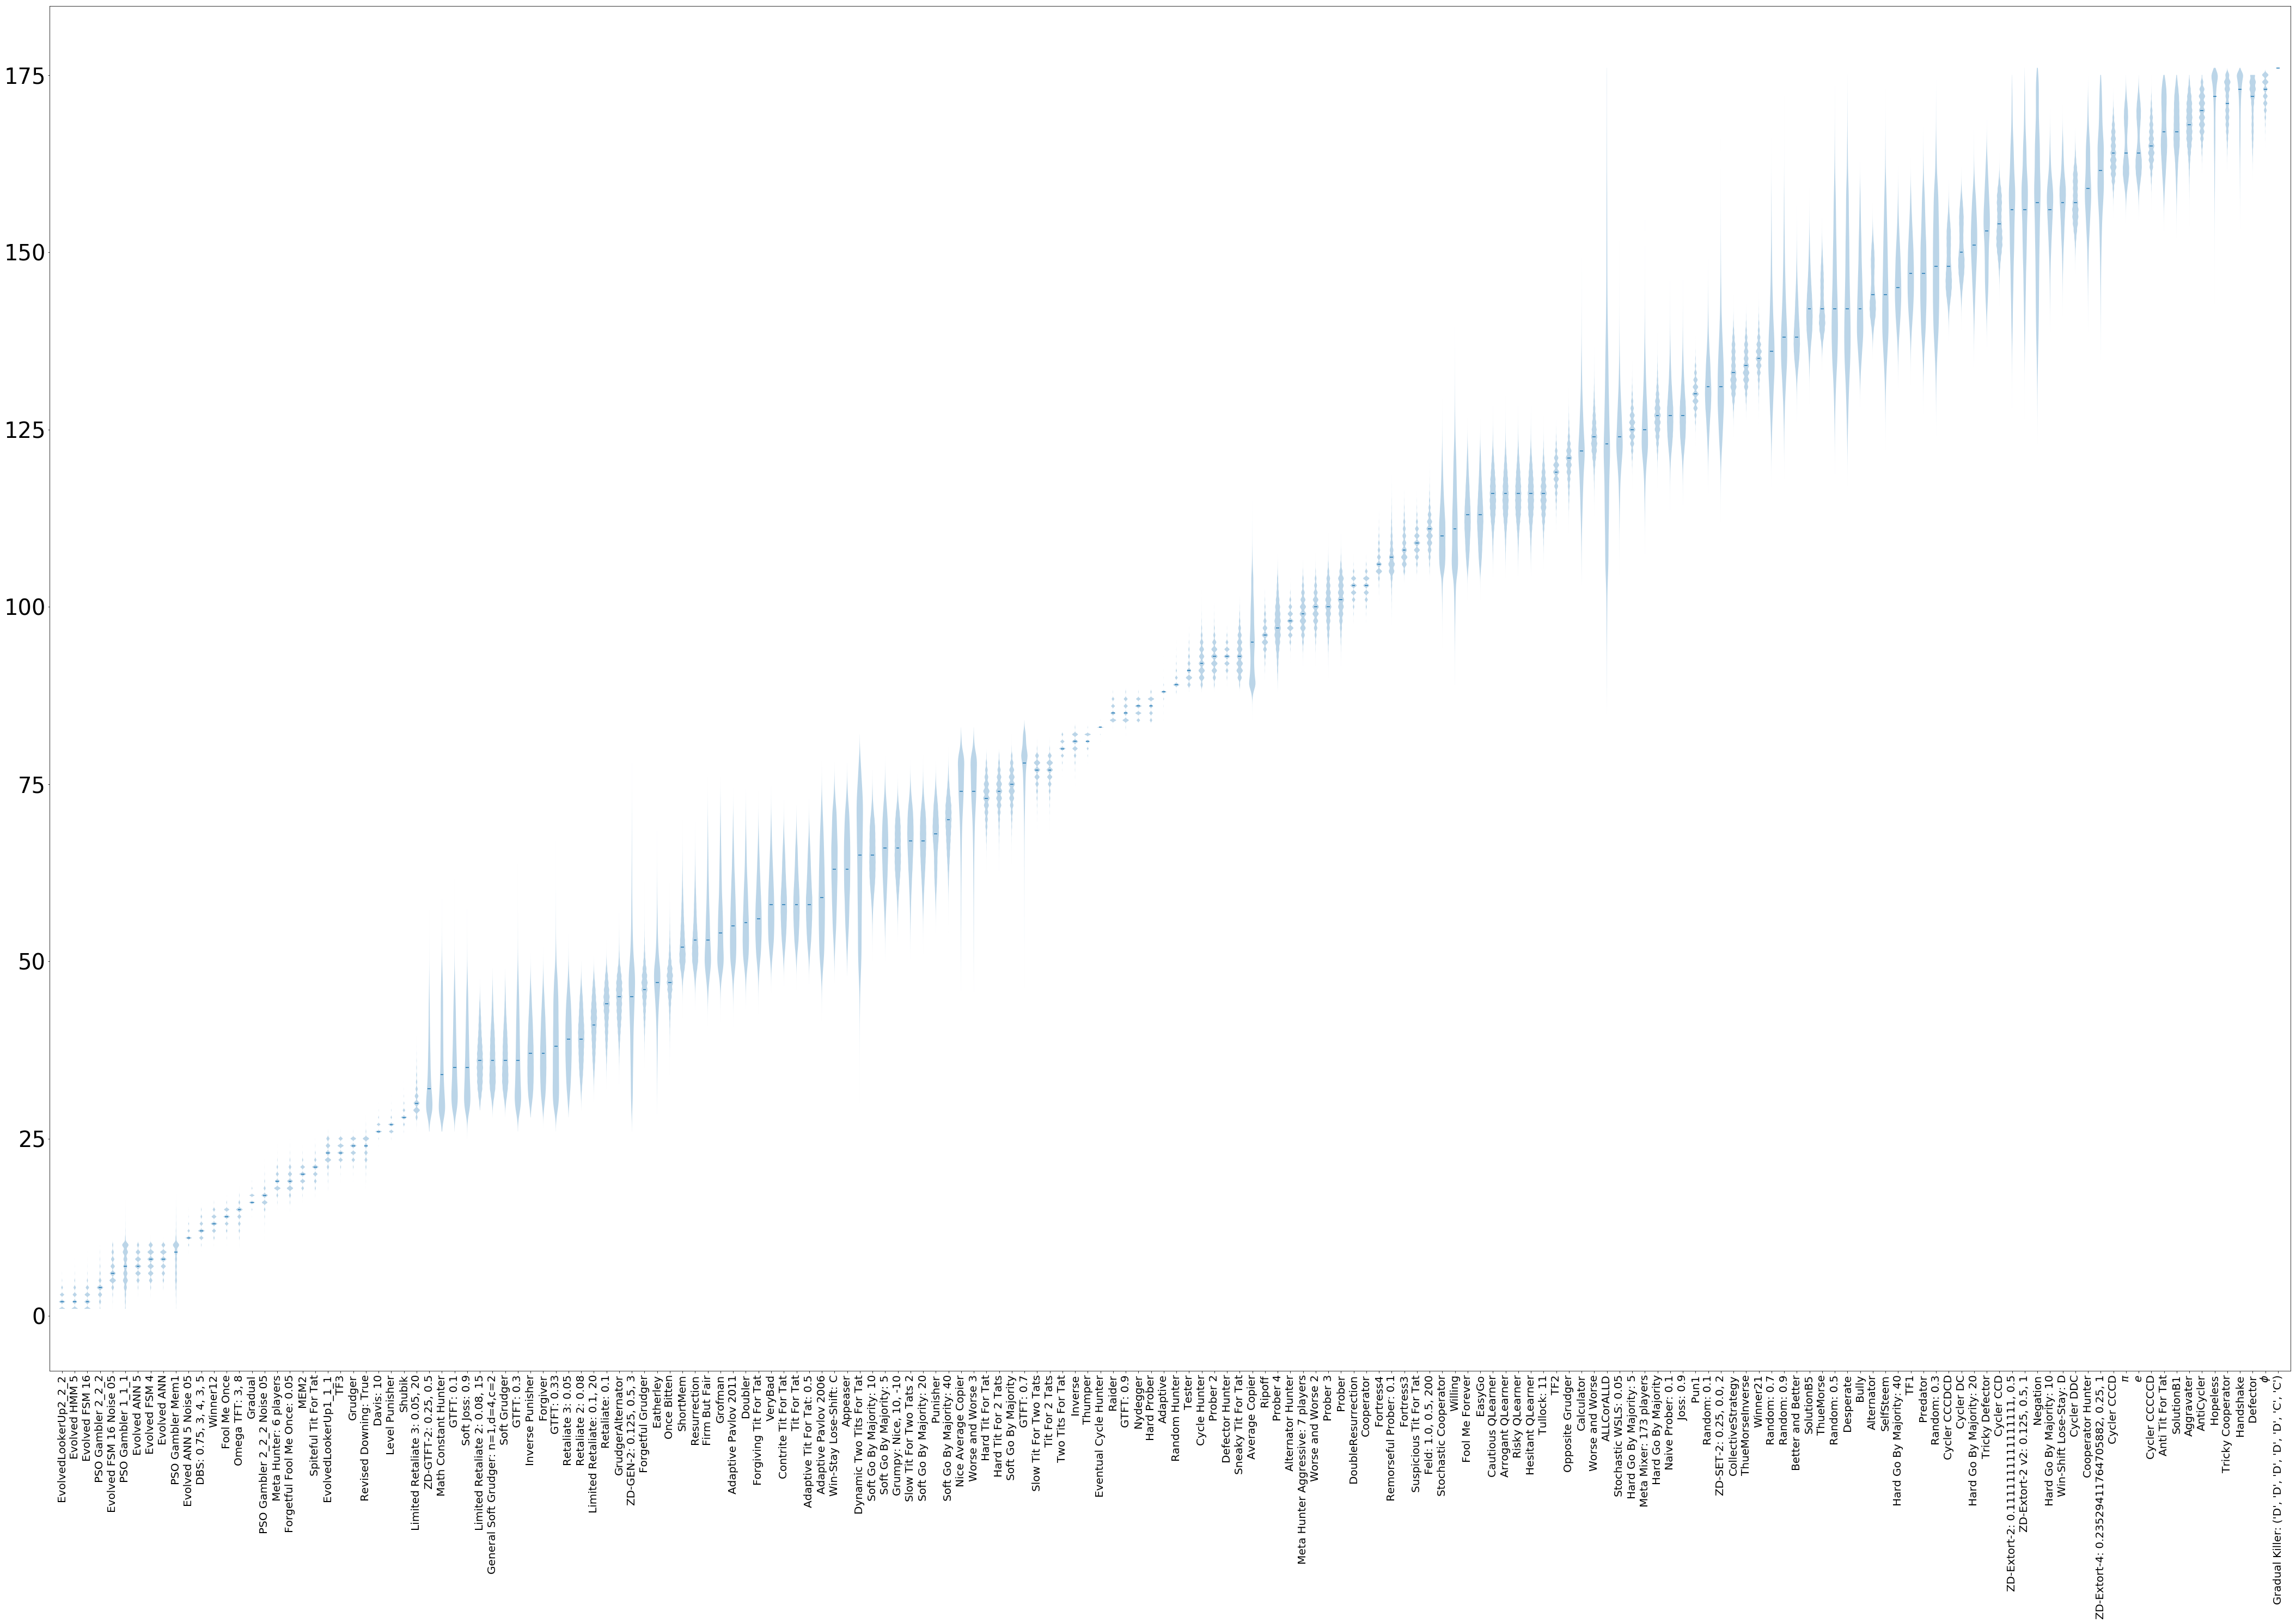

In [11]:
violon_plot(scores.rank(axis=1, ascending=False), rank_summary, "../assets/standard_ranks_boxplots.pdf")

## Payoff matrix

As all the individual payoff matrix files have the mean values and they all have the same number of repetitions, the mean of the means is the mean over all tournaments.

In [12]:
def read_payoff_matrix(files):
    arrays = []
    for gz in files:
        if "payoff_matrix" in gz:
            arrays.append(np.array(pd.read_csv(gz, header=None)))  # Read through pd to deal with float conversion
    return sum(arrays) / len(arrays)

In [13]:
payoff_matrix = read_payoff_matrix(files=standard_files)
assert payoff_matrix.shape == (176, 176)

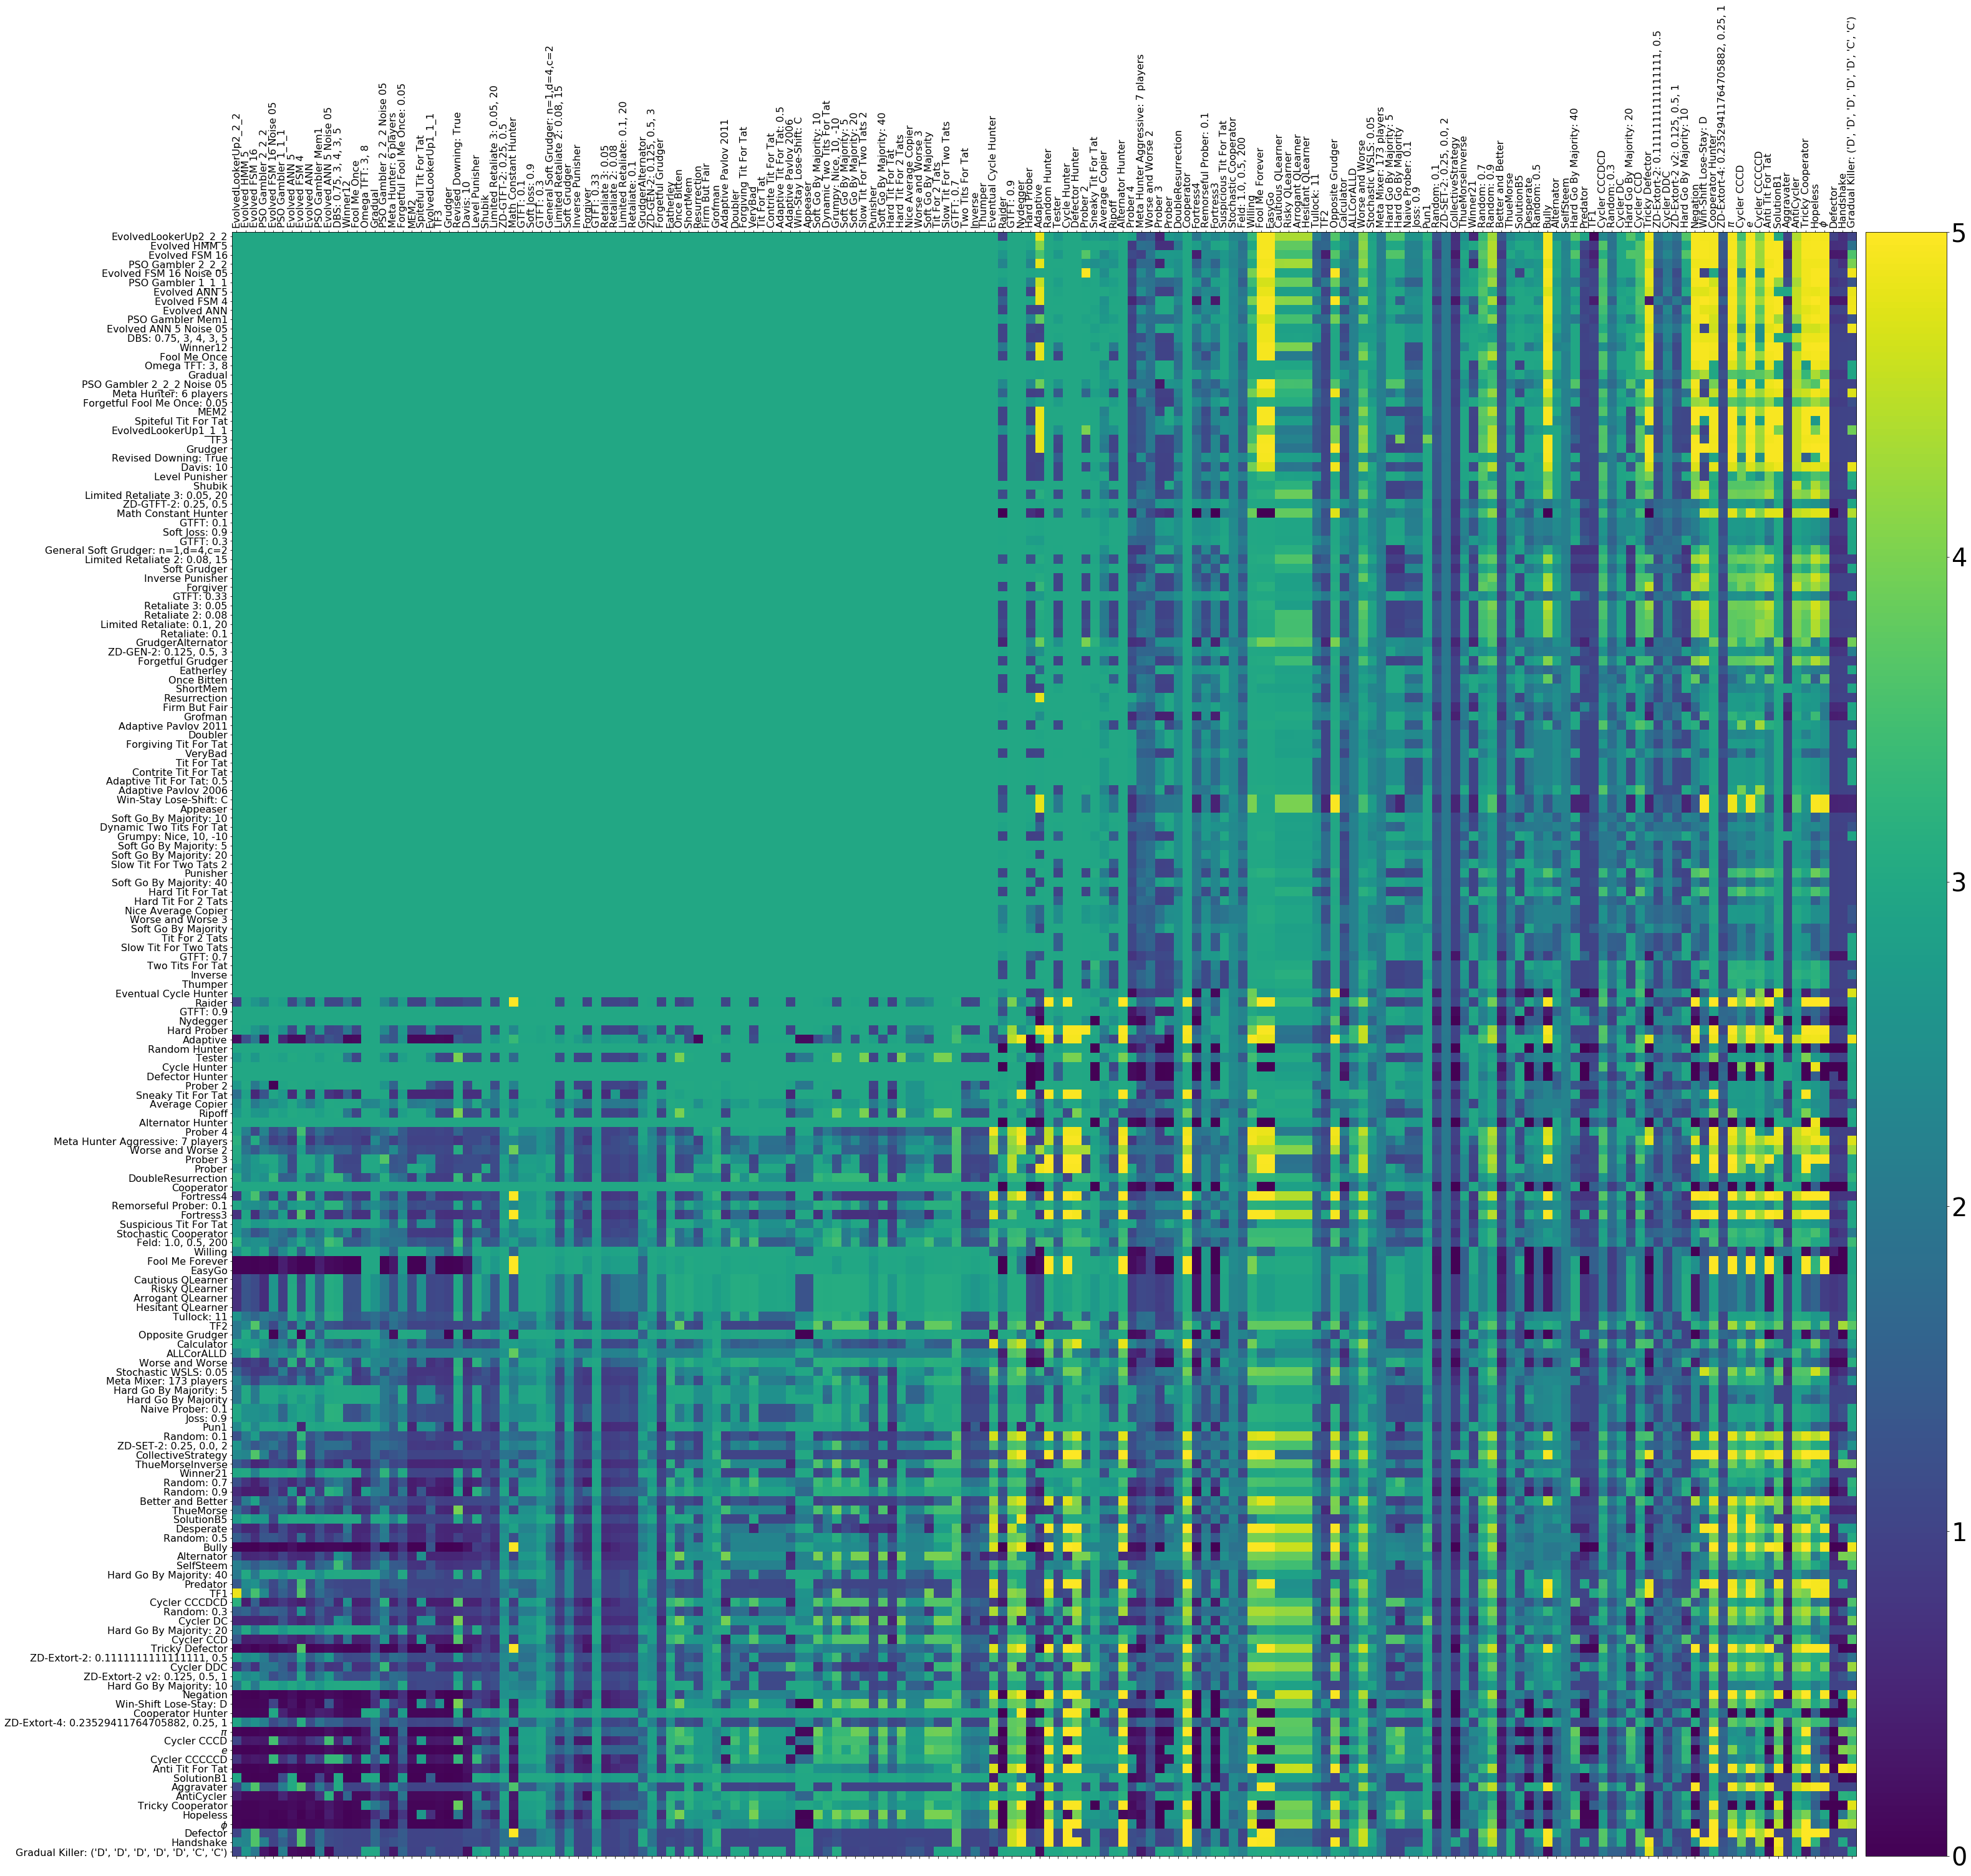

In [14]:
def payoff_heatmap(matrix, player_names, filename):
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(matrix)

    ax.set_xticks(range(number_of_players))
    ax.set_yticks(range(number_of_players))
    ax.set_xticklabels(player_names, rotation=90)
    ax.set_yticklabels(player_names)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cax.tick_params(labelsize=40) 
    fig.colorbar(mat, cax=cax)

    fig.tight_layout()
    fig.savefig(filename);
    
ranked_player_names = list(score_summary.index)
ranked_indices = [player_names.index(name) for name in ranked_player_names]
ranked_payoff_matrix = payoff_matrix[ranked_indices][:, ranked_indices]

for i, _ in enumerate(player_names):  # Check that ordering has been done correctly
    assert payoff_matrix[i, i] == ranked_payoff_matrix[ranked_indices.index(i), ranked_indices.index(i)]

payoff_heatmap(ranked_payoff_matrix, ranked_player_names, "../assets/standard_scores_heatmap.pdf")

## Head to head wins

In [15]:
def read_wins(files):
    dfs = []
    for gz in files:
        if "wins" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    return df

In [16]:
wins = read_wins(files=standard_files)

In [17]:
def summarise_wins(wins, score_summary):
    df = wins.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    for var in ["min", "max"]:
        df[var] = df[var].astype(int)
    df.drop('count', axis=1, inplace=True)
    return df.loc[score_summary.index]

win_summary = summarise_wins(wins, score_summary)
win_summary.head(15)

mean       std  min    5%   25%   50%   75%  \
EvolvedLookerUp2_2_2     48.259512  1.336699   43  46.0  47.0  48.0  49.0   
Evolved HMM 5            41.357140  1.220331   37  39.0  41.0  41.0  42.0   
Evolved FSM 16           56.977605  1.100303   51  55.0  56.0  57.0  58.0   
PSO Gambler 2_2_2        40.687093  1.092129   36  39.0  40.0  41.0  41.0   
Evolved FSM 16 Noise 05  40.074535  1.671129   34  37.0  39.0  40.0  41.0   
PSO Gambler 1_1_1        45.003605  1.594751   38  42.0  44.0  45.0  46.0   
Evolved ANN 5            43.225465  0.674616   41  42.0  43.0  43.0  44.0   
Evolved FSM 4            37.226302  0.951226   34  36.0  37.0  37.0  38.0   
Evolved ANN              43.098000  1.019417   40  42.0  42.0  43.0  44.0   
PSO Gambler Mem1         43.442488  1.837144   34  40.0  42.0  43.0  45.0   
Evolved ANN 5 Noise 05   33.710116  1.124080   30  32.0  33.0  34.0  34.0   
DBS: 0.75, 3, 4, 3, 5    32.329302  1.197075   28  30.0  32.0  32.0  33.0   
Winner12                 40.175256  1.036703   36  39.0  39.0  40.0  41.0   
Fool Me Once             50.121209  0.422793   48  50.0  50.0  50.0  50.0   
Omega TFT: 3, 8          35.158279  0.859495   32  34.0  35.0  35.0  36.0   

                          95%  max  
EvolvedLookerUp2_2_2     50.0   53  
Evolved HMM 5            43.0   45  
Evolved FSM 16           59.0   60  
PSO Gambler 2_2_2        42.0   45  
Evolved FSM 16 Noise 05  43.0   47  
PSO Gambler 1_1_1        48.0   51  
Evolved ANN 5            44.0   47  
Evolved FSM 4            39.0   41  
Evolved ANN              45.0   48  
PSO Gambler Mem1         46.0   51  
Evolved ANN 5 Noise 05   35.0   38  
DBS: 0.75, 3, 4, 3, 5    34.0   37  
Winner12                 42.0   44  
Fool Me Once             51.0   52  
Omega TFT: 3, 8          37.0   39

In [18]:
win_summary.sort_values("mean", ascending=False).head(15)

mean       std  min     5%  \
Defector                                   161.603465  0.862937  160  160.0   
Aggravater                                 161.594535  0.861670  160  160.0   
CollectiveStrategy                         159.645279  1.006854  155  158.0   
ZD-Extort-4: 0.23529411764705882, 0.25, 1  150.597209  2.665511  138  146.0   
Handshake                                  149.552698  1.750984  142  147.0   
ZD-Extort-2 v2: 0.125, 0.5, 1              146.292349  3.431054  132  141.0   
ZD-Extort-2: 0.1111111111111111, 0.5       146.094814  3.444592  129  140.0   
Winner21                                   139.946186  1.226310  136  138.0   
TF2                                        138.241093  1.699689  131  135.0   
Feld: 1.0, 0.5, 200                        136.084977  1.695948  130  133.0   
Naive Prober: 0.1                          136.011233  2.506837  127  132.0   
Joss: 0.9                                  136.005209  2.500461  126  132.0   
TF1                                        135.692721  1.407066  130  133.0   
Predator                                   133.719395  1.382786  129  131.0   
SolutionB5                                 125.844953  1.508592  120  123.0   

                                             25%    50%    75%    95%  max  
Defector                                   161.0  162.0  162.0  163.0  163  
Aggravater                                 161.0  162.0  162.0  163.0  163  
CollectiveStrategy                         159.0  160.0  160.0  161.0  161  
ZD-Extort-4: 0.23529411764705882, 0.25, 1  149.0  151.0  152.0  155.0  162  
Handshake                                  148.0  150.0  151.0  152.0  154  
ZD-Extort-2 v2: 0.125, 0.5, 1              144.0  146.0  149.0  152.0  160  
ZD-Extort-2: 0.1111111111111111, 0.5       144.0  146.0  148.0  152.0  160  
Winner21                                   139.0  140.0  141.0  142.0  143  
TF2                                        137.0  138.0  139.0  141.0  143  
Feld: 1.0, 0.5, 200                        135.0  136.0  137.0  139.0  143  
Naive Prober: 0.1                          134.0  136.0  138.0  140.0  147  
Joss: 0.9                                  134.0  136.0  138.0  140.0  146  
TF1                                        135.0  136.0  137.0  138.0  140  
Predator                                   133.0  134.0  135.0  136.0  138  
SolutionB5                                 125.0  126.0  127.0  128.0  131

In [19]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.head(15).round(number_of_digits).to_latex()))

In [20]:
# Write the top 15 winning players to a tex table
with open("../assets/standard_top_15_winners_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.sort_values("50%", ascending=False).head(15).round(number_of_digits).to_latex()))

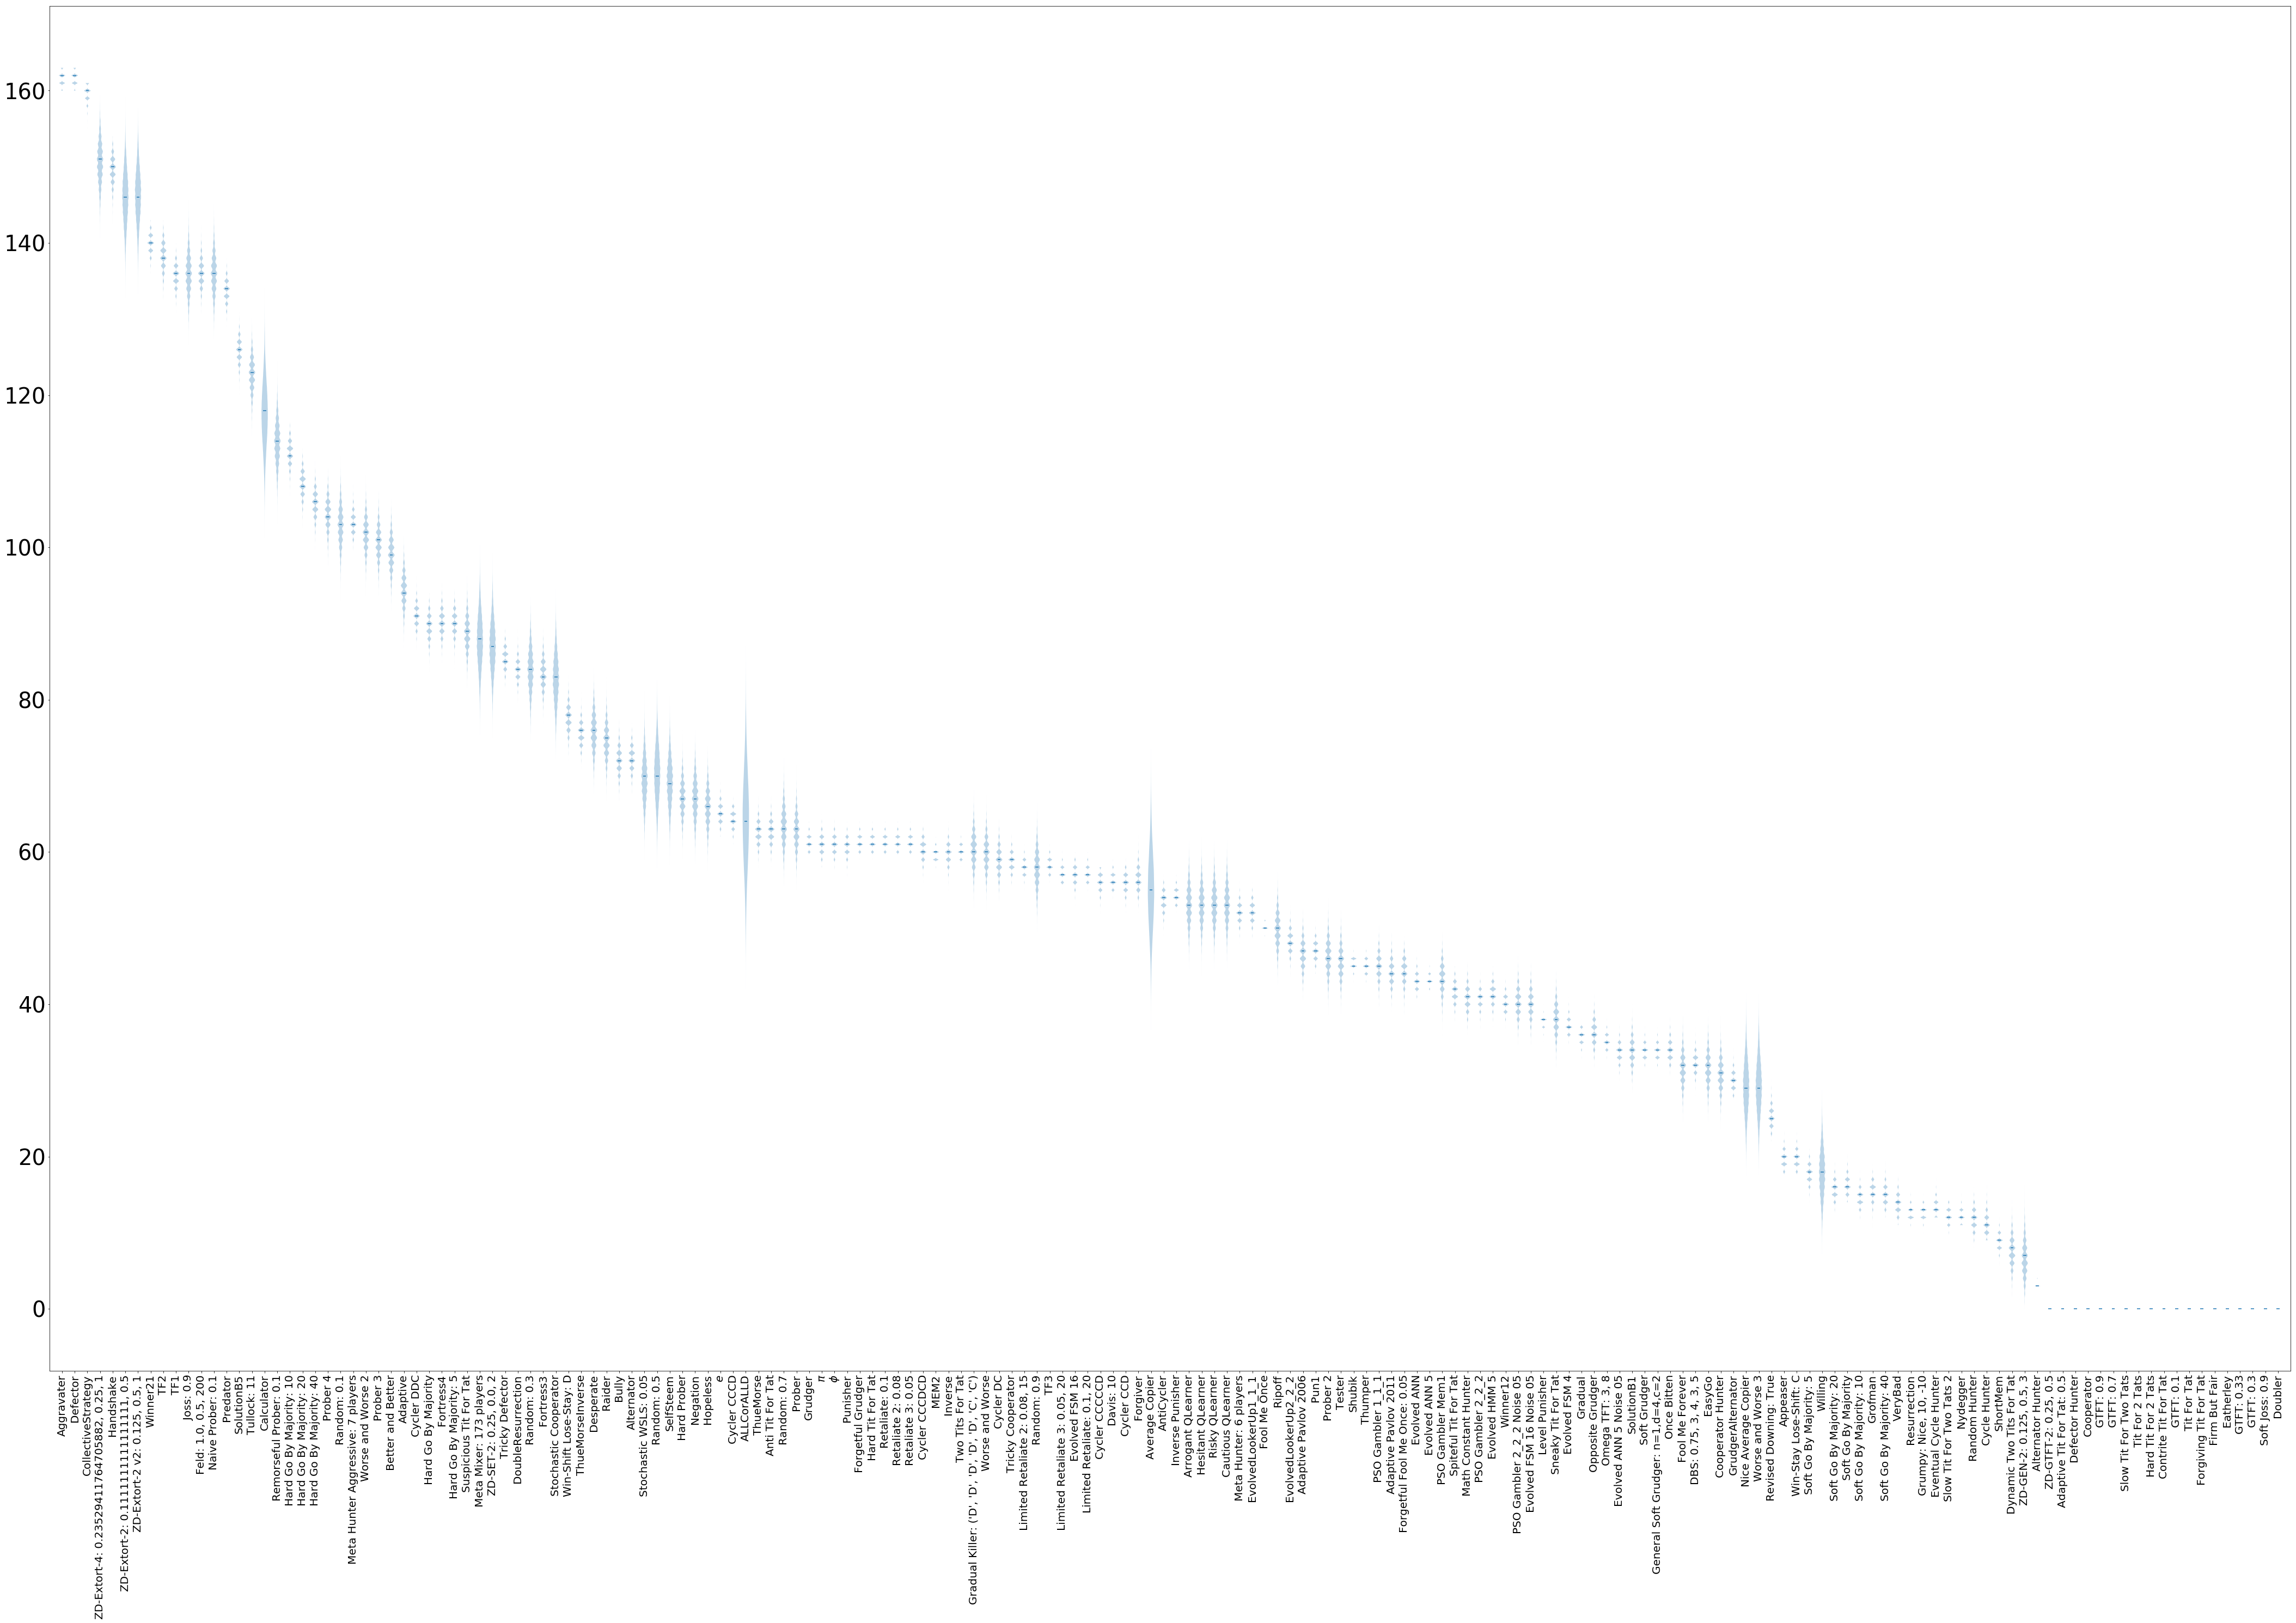

In [21]:
win_summary = win_summary.sort_values("50%", ascending=False)
violon_plot(wins, win_summary, "../assets/standard_wins_boxplots.pdf")

# Study the noisy tournaments


## Scores

In [22]:
noisy_files = glob.glob("./data/*_5_1000*gz")
scores = read_scores(files=noisy_files)

In [23]:
with open("../assets/noisy_number_of_repetitions.tex", "w") as f:
    f.write(str(len(scores.index)))

In [24]:
score_summary = summarise_scores(scores)
score_summary.head(15)

mean       std       min        5%       25%  \
DBS: 0.75, 3, 4, 3, 5       2.572745  0.024606  2.473857  2.532970  2.556086   
Evolved ANN 5 Noise 05      2.533794  0.025392  2.417857  2.491543  2.516886   
Evolved FSM 16 Noise 05     2.514862  0.030820  2.374400  2.464143  2.494200   
Evolved ANN 5               2.409499  0.030351  2.289800  2.359341  2.389171   
Evolved FSM 4               2.392742  0.027022  2.286343  2.348284  2.374486   
Evolved HMM 5               2.391712  0.026121  2.289457  2.348457  2.373943   
Level Punisher              2.388435  0.025045  2.280600  2.347029  2.371600   
Omega TFT: 3, 8             2.387203  0.026197  2.269514  2.343457  2.369571   
Spiteful Tit For Tat        2.383139  0.029776  2.259200  2.334486  2.363057   
Evolved FSM 16              2.374941  0.029484  2.244714  2.325829  2.355371   
PSO Gambler 2_2_2 Noise 05  2.370739  0.028855  2.249514  2.322857  2.351600   
Adaptive                    2.369154  0.038046  2.217486  2.306314  2.343743   
Evolved ANN                 2.365469  0.021911  2.275829  2.329286  2.350829   
Math Constant Hunter        2.344135  0.022420  2.257286  2.307971  2.329029   
Gradual                     2.341050  0.021240  2.247943  2.305771  2.326771   

                                 50%       75%       95%       max  
DBS: 0.75, 3, 4, 3, 5       2.572629  2.589200  2.613771  2.674543  
Evolved ANN 5 Noise 05      2.534229  2.551143  2.574886  2.629000  
Evolved FSM 16 Noise 05     2.515057  2.535800  2.565316  2.642143  
Evolved ANN 5               2.409543  2.430057  2.458971  2.535771  
Evolved FSM 4               2.392714  2.411086  2.437086  2.505114  
Evolved HMM 5               2.391771  2.409457  2.434887  2.493457  
Level Punisher              2.388629  2.405400  2.429259  2.487286  
Omega TFT: 3, 8             2.387529  2.405057  2.429714  2.498114  
Spiteful Tit For Tat        2.383171  2.403029  2.432229  2.516771  
Evolved FSM 16              2.375457  2.394886  2.422859  2.507000  
PSO Gambler 2_2_2 Noise 05  2.370971  2.390286  2.417771  2.480200  
Adaptive                    2.369286  2.395036  2.431486  2.523629  
Evolved ANN                 2.365543  2.380143  2.401543  2.482857  
Math Constant Hunter        2.343743  2.358943  2.381886  2.435800  
Gradual                     2.341300  2.355514  2.375714  2.429371

In [25]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(score_summary.head(15).round(number_of_digits).to_latex()))

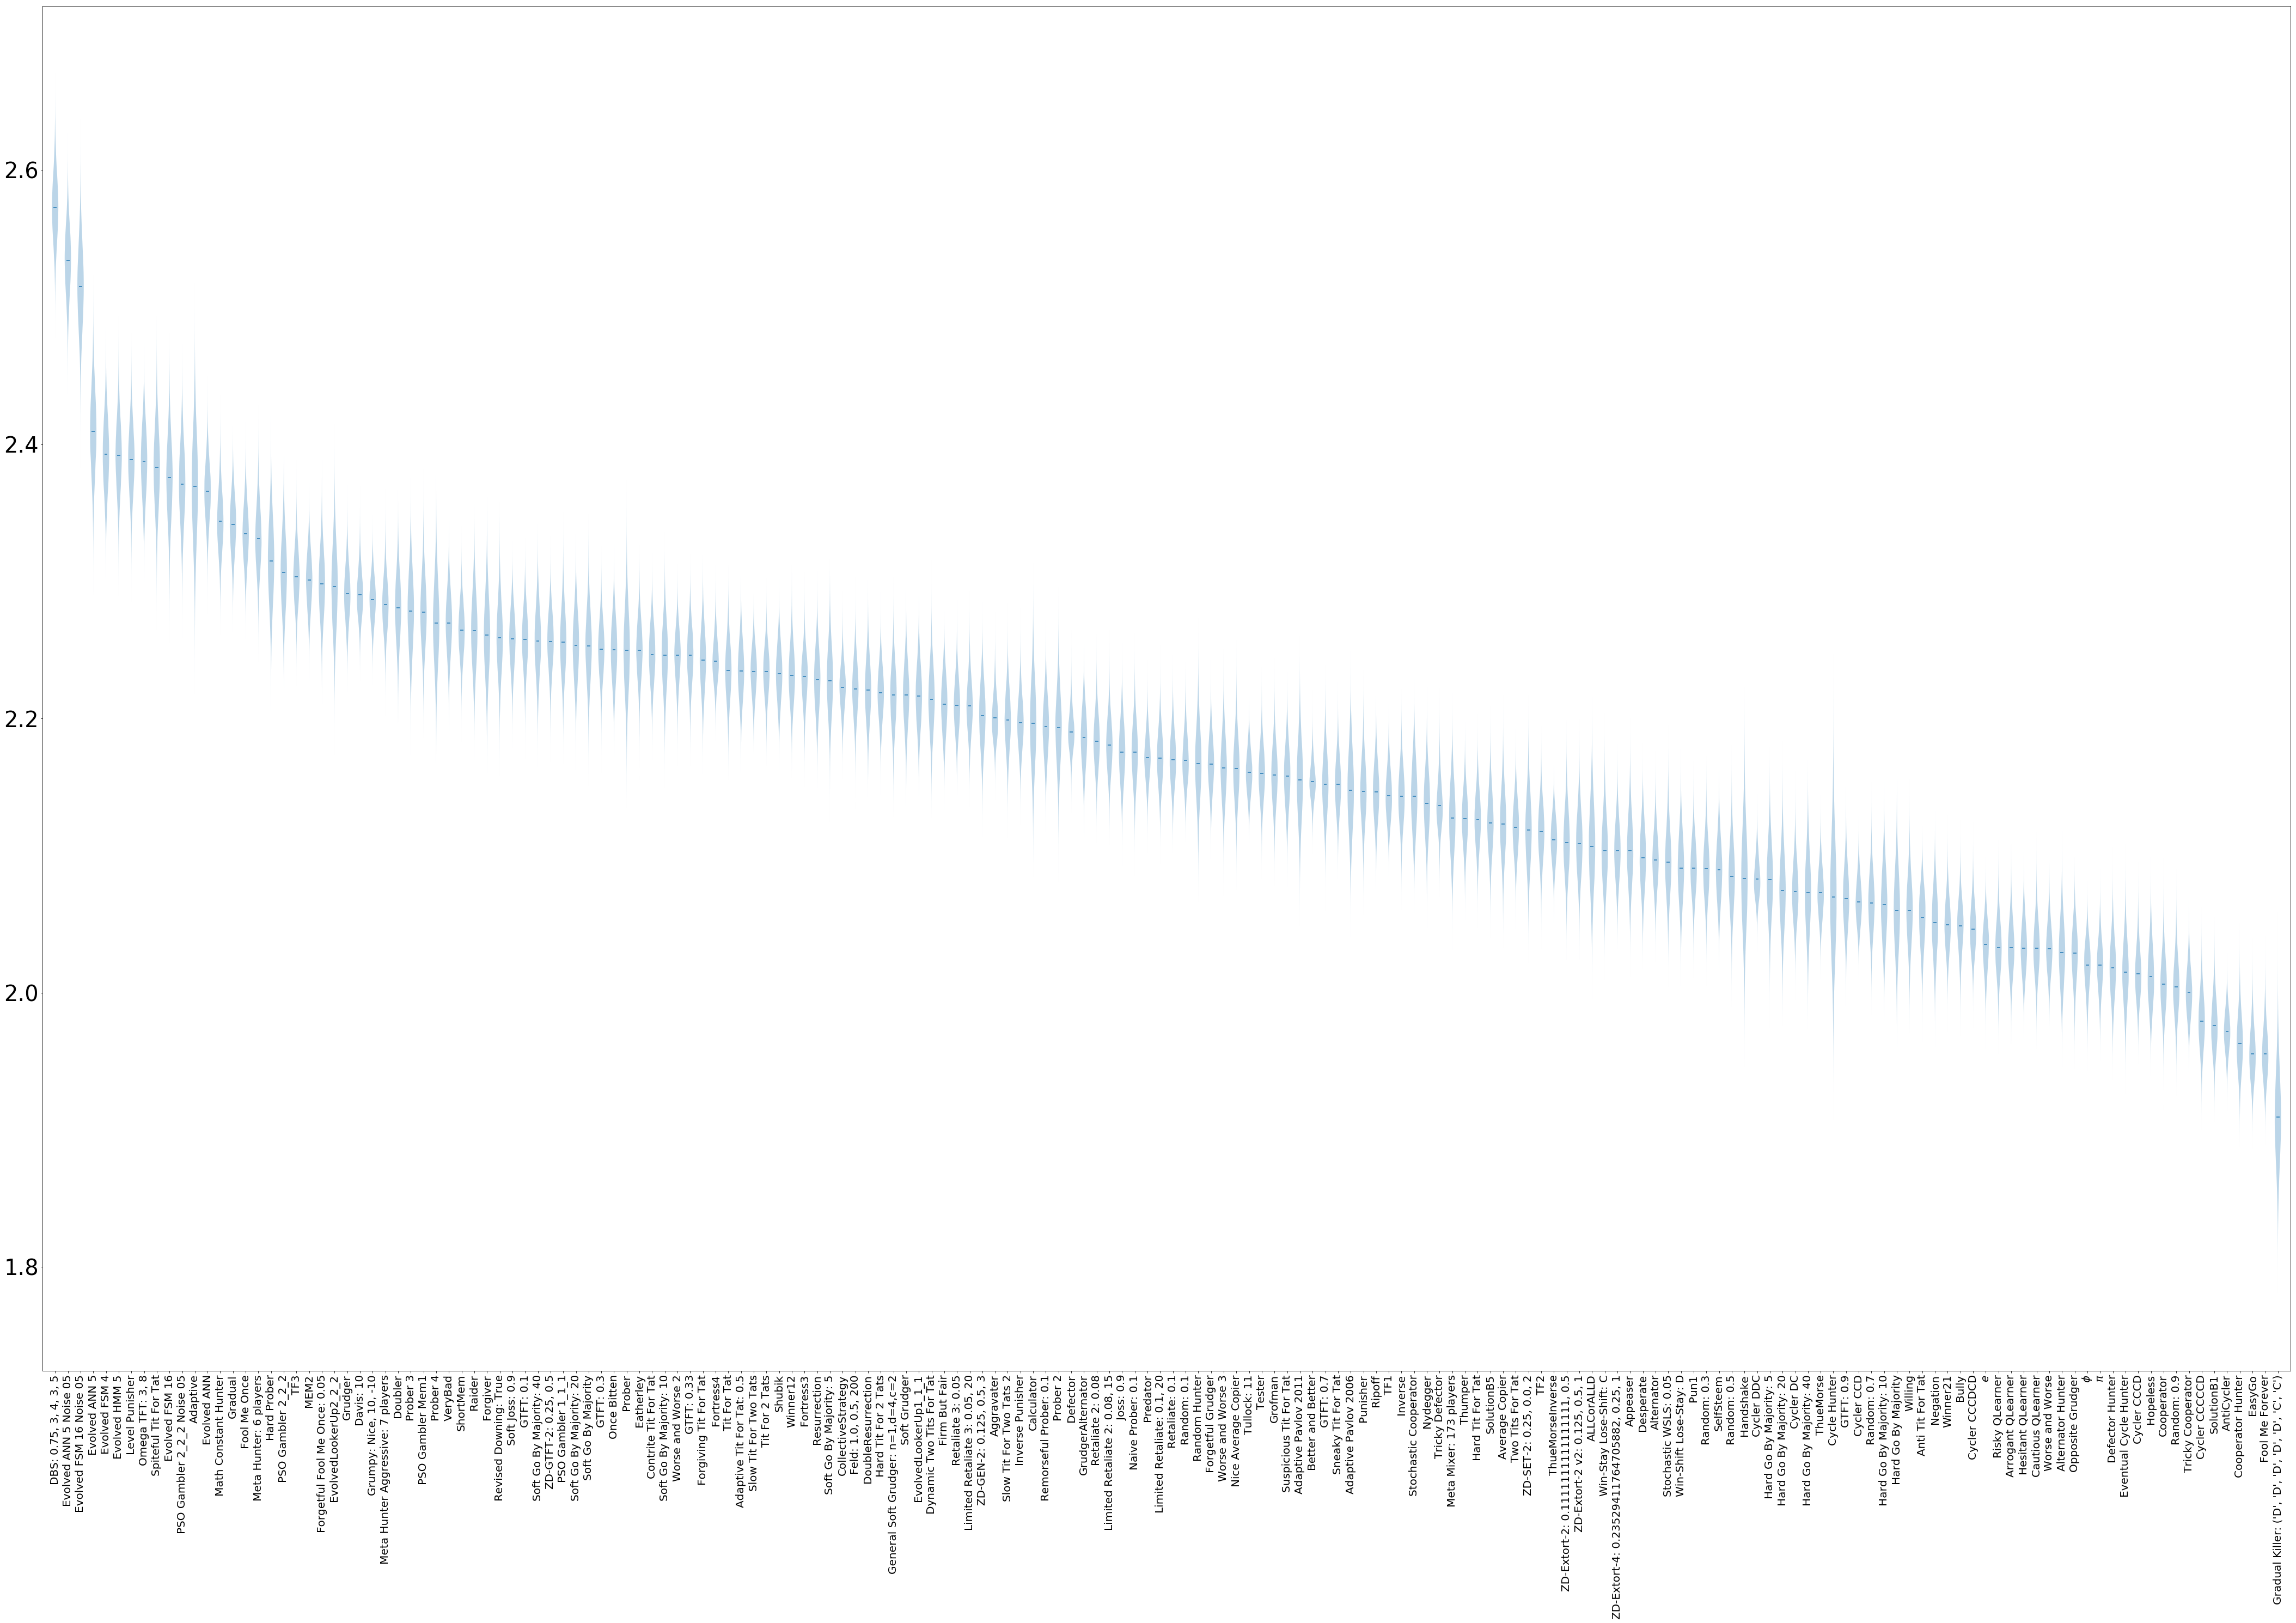

In [26]:
violon_plot(scores, score_summary, "../assets/noisy_scores_boxplots.pdf")

## Ranks

In [27]:
rank_summary = summarise_ranks(scores)
rank_summary.head(15)

mean       std  min    5%   25%   50%   75%  \
DBS: 0.75, 3, 4, 3, 5        1.205489  0.467307    1   1.0   1.0   1.0   1.0   
Evolved ANN 5 Noise 05       2.183170  0.629238    1   1.0   2.0   2.0   3.0   
Evolved FSM 16 Noise 05      2.626739  0.618565    1   1.0   2.0   3.0   3.0   
Evolved ANN 5                6.372420  2.786623    2   4.0   4.0   5.0   8.0   
Evolved FSM 4                7.918420  3.176034    3   4.0   5.0   7.0  10.0   
Evolved HMM 5                7.995489  3.111115    3   4.0   6.0   7.0  10.0   
Level Punisher               8.338080  3.082753    3   4.0   6.0   8.0  10.0   
Omega TFT: 3, 8              8.516375  3.254925    3   4.0   6.0   8.0  11.0   
Spiteful Tit For Tat         9.159716  3.769567    3   4.0   6.0   9.0  12.0   
Evolved FSM 16              10.207091  4.095691    3   4.0   7.0  10.0  13.0   
PSO Gambler 2_2_2 Noise 05  10.769784  4.104451    3   5.0   8.0  10.0  13.0   
Evolved ANN                 11.352670  3.255329    3   6.0   9.0  11.0  13.0   
Adaptive                    11.412227  5.743437    3   4.0   7.0  11.0  14.0   
Math Constant Hunter        14.669932  3.793908    3   9.0  12.0  15.0  17.0   
Gradual                     15.162011  3.674593    4  10.0  13.0  15.0  17.0   

                             95%  max  
DBS: 0.75, 3, 4, 3, 5        2.0    3  
Evolved ANN 5 Noise 05       3.0    5  
Evolved FSM 16 Noise 05      3.0    9  
Evolved ANN 5               12.0   25  
Evolved FSM 4               14.0   33  
Evolved HMM 5               14.0   26  
Level Punisher              14.0   26  
Omega TFT: 3, 8             14.0   32  
Spiteful Tit For Tat        16.0   40  
Evolved FSM 16              17.0   51  
PSO Gambler 2_2_2 Noise 05  18.0   47  
Evolved ANN                 17.0   32  
Adaptive                    21.0   63  
Math Constant Hunter        21.0   43  
Gradual                     21.0   49

In [28]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(rank_summary.head(15).round(number_of_digits).to_latex()))

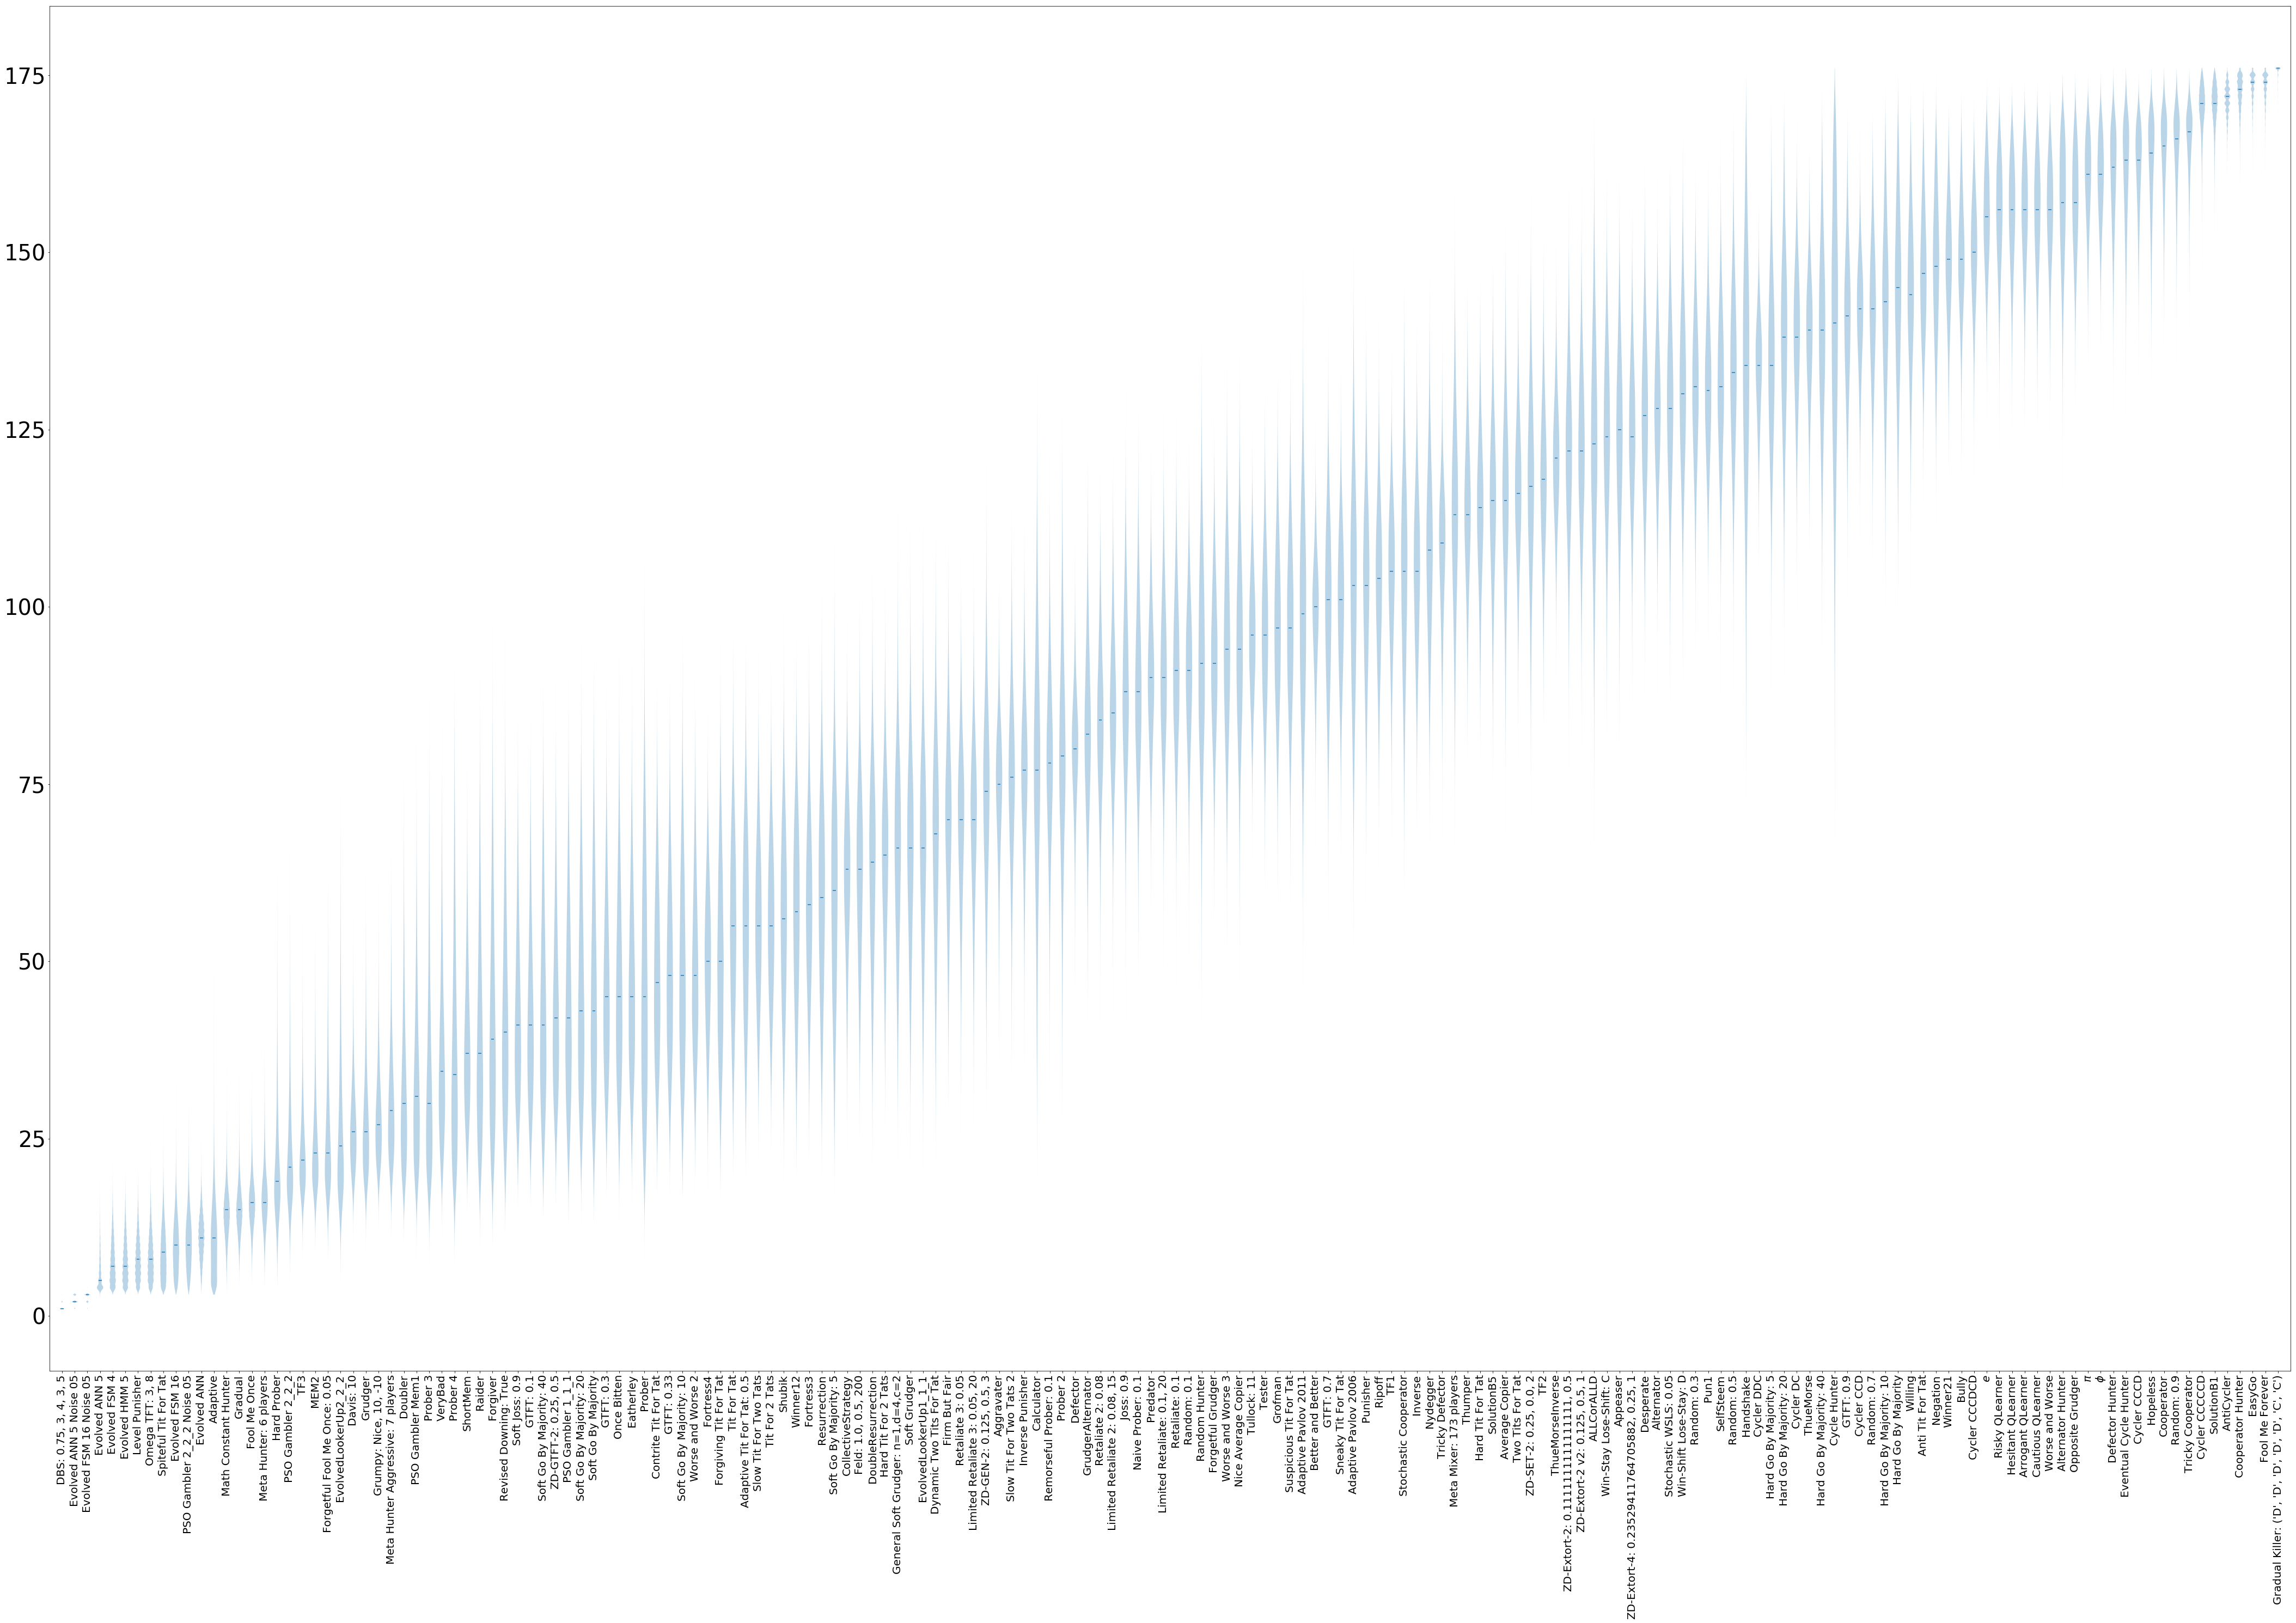

In [29]:
violon_plot(scores.rank(axis=1, ascending=False), rank_summary, "../assets/noisy_ranks_boxplots.pdf")

## Payoff matrix

In [30]:
payoff_matrix = read_payoff_matrix(files=noisy_files)
assert payoff_matrix.shape == (176, 176)

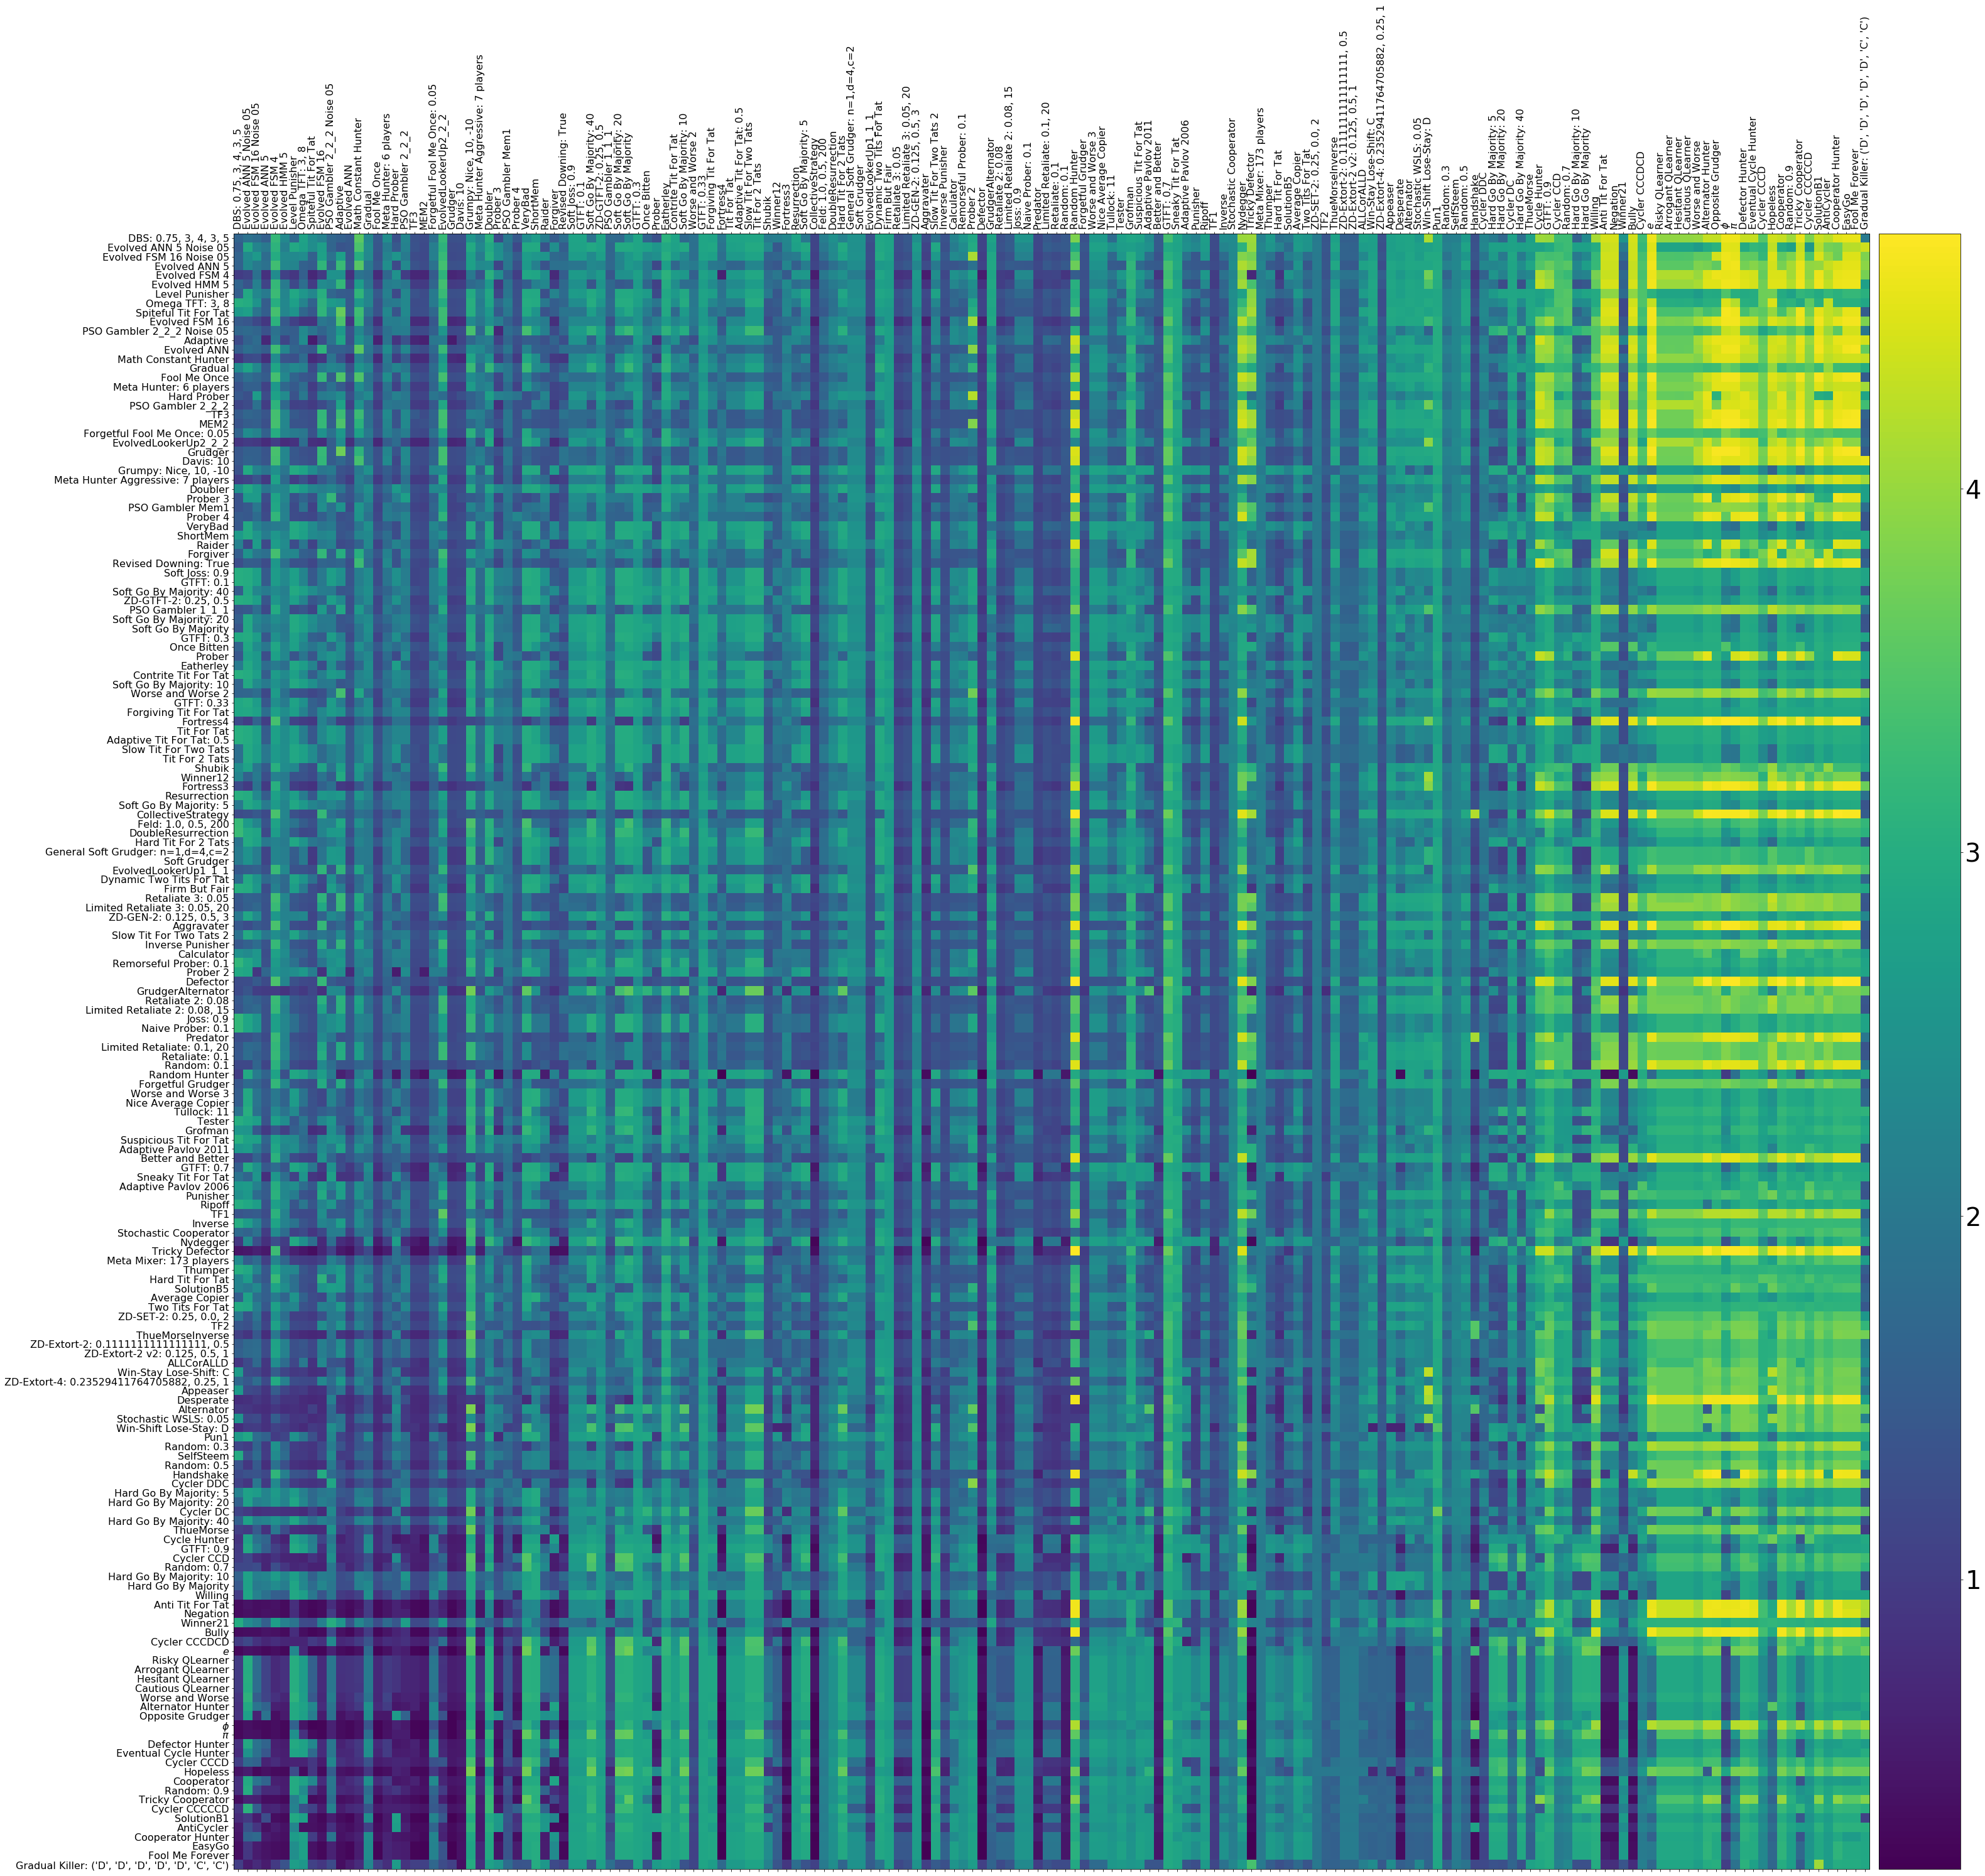

In [31]:
ranked_player_names = list(score_summary.index)
ranked_indices = [player_names.index(name) for name in ranked_player_names]
ranked_payoff_matrix = payoff_matrix[ranked_indices][:, ranked_indices]

for i, _ in enumerate(player_names):  # Check that ordering has been done correctly
    assert payoff_matrix[i, i] == ranked_payoff_matrix[ranked_indices.index(i), ranked_indices.index(i)]

payoff_heatmap(ranked_payoff_matrix, ranked_player_names, "../assets/noisy_scores_heatmap.pdf")

## Wins

In [32]:
wins = read_wins(files=noisy_files)

In [33]:
win_summary = summarise_wins(wins, score_summary)
win_summary.head(15)

mean       std  min     5%    25%    50%  \
DBS: 0.75, 3, 4, 3, 5       102.546114  3.671215   87   97.0  100.0  103.0   
Evolved ANN 5 Noise 05       75.025591  4.225413   57   68.0   72.0   75.0   
Evolved FSM 16 Noise 05      88.699773  3.869898   74   82.0   86.0   89.0   
Evolved ANN 5               137.873182  4.358047  118  131.0  135.0  138.0   
Evolved FSM 4                74.247477  2.687579   64   70.0   72.0   74.0   
Evolved HMM 5                88.187636  2.778925   77   84.0   86.0   88.0   
Level Punisher               94.272500  4.783622   77   86.0   91.0   94.0   
Omega TFT: 3, 8             131.661909  4.297015  112  125.0  129.0  132.0   
Spiteful Tit For Tat        155.037432  3.325851  133  150.0  153.0  155.0   
Evolved FSM 16              103.284341  3.631756   89   97.0  101.0  103.0   
PSO Gambler 2_2_2 Noise 05   90.500773  4.018039   75   84.0   88.0   90.0   
Adaptive                    101.885727  4.897953   84   94.0   99.0  102.0   
Evolved ANN                 138.505886  3.397225  125  133.0  136.0  139.0   
Math Constant Hunter         93.007205  3.261697   79   88.0   91.0   93.0   
Gradual                     101.899455  2.867797   91   97.0  100.0  102.0   

                              75%    95%  max  
DBS: 0.75, 3, 4, 3, 5       105.0  109.0  118  
Evolved ANN 5 Noise 05       78.0   82.0   93  
Evolved FSM 16 Noise 05      91.0   95.0  104  
Evolved ANN 5               141.0  145.0  156  
Evolved FSM 4                76.0   79.0   85  
Evolved HMM 5                90.0   93.0   99  
Level Punisher               97.0  102.0  116  
Omega TFT: 3, 8             135.0  139.0  150  
Spiteful Tit For Tat        157.0  160.0  167  
Evolved FSM 16              106.0  109.0  118  
PSO Gambler 2_2_2 Noise 05   93.0   97.0  109  
Adaptive                    105.0  110.0  124  
Evolved ANN                 141.0  144.0  153  
Math Constant Hunter         95.0   98.0  107  
Gradual                     104.0  107.0  114

In [34]:
win_summary.sort_values("mean", ascending=False).head(15)

mean       std  min     5%    25%    50%    75%  \
Defector              157.329682  3.253747  144  152.0  155.0  157.0  160.0   
CollectiveStrategy    156.873955  3.258728  144  151.0  155.0  157.0  159.0   
Aggravater            156.656364  3.326639  141  151.0  154.0  157.0  159.0   
Grudger               155.587341  3.305454  143  150.0  153.0  156.0  158.0   
Retaliate 3: 0.05     155.382023  3.305672  141  150.0  153.0  155.0  158.0   
Retaliate: 0.1        155.375841  3.317662  139  150.0  153.0  155.0  158.0   
Retaliate 2: 0.08     155.367295  3.321405  140  150.0  153.0  155.0  158.0   
Hard Tit For Tat      155.294864  3.348465  141  150.0  153.0  155.0  158.0   
MEM2                  155.054341  3.354503  140  149.0  153.0  155.0  157.0   
Spiteful Tit For Tat  155.037432  3.325851  133  150.0  153.0  155.0  157.0   
Punisher              153.281068  3.376767  140  148.0  151.0  153.0  156.0   
TF3                   153.032023  3.330612  138  148.0  151.0  153.0  155.0   
Fool Me Once          152.820795  3.349102  138  147.0  151.0  153.0  155.0   
Two Tits For Tat      152.820000  3.426608  138  147.0  151.0  153.0  155.0   
Forgetful Grudger     151.459977  3.447448  132  146.0  149.0  151.0  154.0   

                        95%  max  
Defector              163.0  170  
CollectiveStrategy    162.0  169  
Aggravater            162.0  170  
Grudger               161.0  168  
Retaliate 3: 0.05     161.0  169  
Retaliate: 0.1        161.0  168  
Retaliate 2: 0.08     161.0  169  
Hard Tit For Tat      161.0  168  
MEM2                  160.0  169  
Spiteful Tit For Tat  160.0  167  
Punisher              159.0  167  
TF3                   158.0  166  
Fool Me Once          158.0  166  
Two Tits For Tat      158.0  165  
Forgetful Grudger     157.0  166

In [35]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.head(15).round(number_of_digits).to_latex()))

In [36]:
# Write the top 15 winning players to a tex table
with open("../assets/noisy_top_15_winners_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.sort_values("50%", ascending=False).head(15).round(number_of_digits).to_latex()))

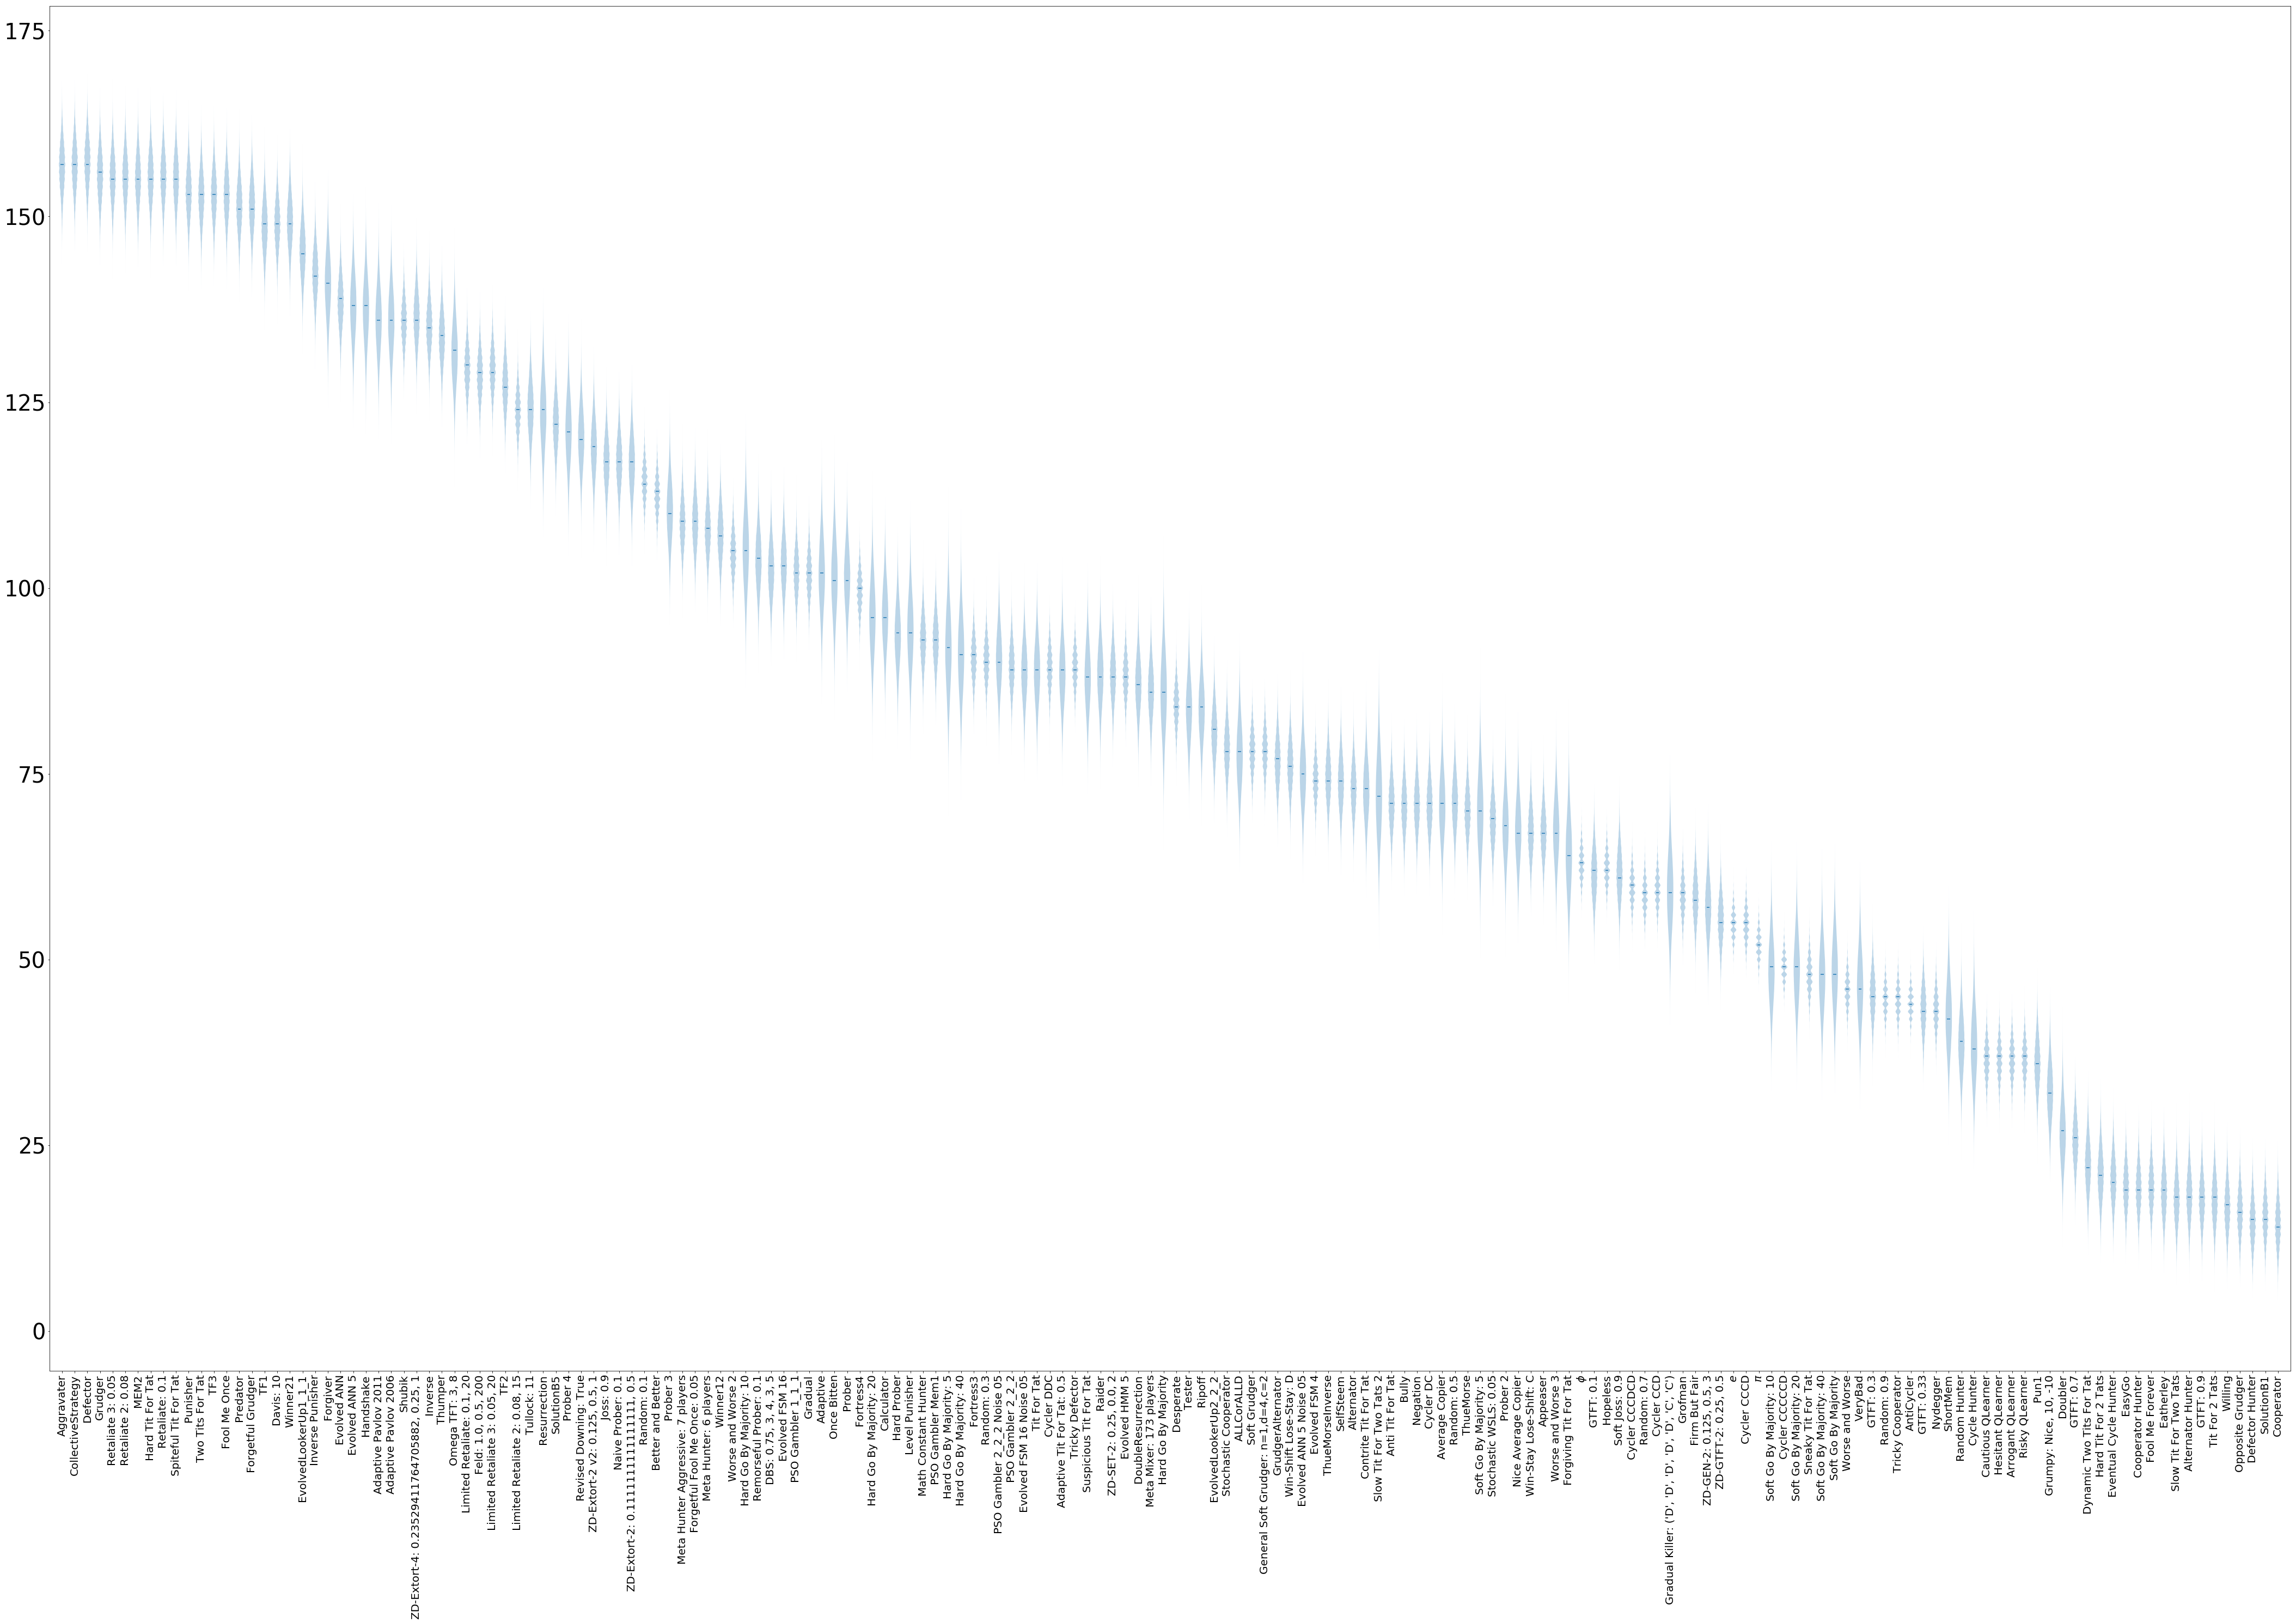

In [37]:
win_summary = win_summary.sort_values("50%", ascending=False)
violon_plot(wins, win_summary, "../assets/noisy_wins_boxplots.pdf")

# Draw cooperation heatmaps

In [ ]:
def cooperation_heatmap(filename, player_names=player_names):
    
    matrix = np.array(pd.read_csv(filename))
    
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(matrix)

    ax.set_yticks(range(number_of_players))
    ax.set_yticklabels(player_names)
    ax.set_xlabel("Rounds", fontsize=40)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cax.tick_params(labelsize=40) 
    cbar = fig.colorbar(mat, cax=cax)
    fig.tight_layout()
    
    base = os.path.basename(filename)
    plot_file_name, _ = os.path.splitext(base)
    
    fig.savefig("../assets/{}.pdf".format(plot_file_name))

In [ ]:
cooperation_files = glob.glob("./data/cooperation_*_array.gz")

for file in cooperation_files:
    cooperation_heatmap(file)